# Import libraries and load data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point, Polygon
%pip install lifelines
from lifelines import CoxPHFitter
import pandas as pd
# Mount Google Drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=35b2fdd6d24e9bc9361009ed70df8b0d08c2601eab90c419d3fb3131391863ae
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
Mounted at /content/drive


In [ ]:
# Load RAW datasets
transactions = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Data set/Shopify/transaction total.csv')
trans_details = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Data set/Shopify/Transaction_details.csv')
products = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Data set/Shopify/products_export_1.csv')
customers = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Data set/Shopify/customers.csv')

#Load CLEANED datasets
#customers_clean = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Cleaned Data/customers_clean.csv')
trans_details_clean = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Cleaned Data/trans_details_clean.csv')
#transactions_clean = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Cleaned Data/transactions_clean.csv')
#trans_details_clean_joined = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /Cleaned Data/trans_details_clean_joined.csv')

#Data Preprocessing

* Dropping Unnecessary Columns

Irrelevant and redundant fields were removed to streamline the dataset and focus on the most informative attributes:
    * Transactions Table
      * Columns such as Kind, Gateway, Card Type, Payment Method, and Currency were dropped. Additionally, failed and pending orders were excluded to ensure that only completed transactions were analyzed.
   * Customers Table
      * Columns related to marketing consent (email/SMS marketing status), phone numbers, customer notes, tax-exempt status, and all address fields besides State and Zip Code.
    * Products Table
     * Metadata, SEO attributes, inventory tracking details, product descriptions, vendor information and international pricing fields. Additionally, the Product Name was excluded since it did not effectively differentiate products the way SKUs do, such as indicating specifications like GPU or PSI.
* Filtered Out Invalid Rows

We removed rows that could distort the analysis or did not reflect real customer behavior:

  * Transactions with negative values (representing returns)
  * Transactions with zero total sales, which typically indicate free shipping, canceled orders, or test orders
  * Transactions with zero quantity which reflects manual adjustments to sales orders due to mistakes and errors
  * Transactions from test accounts using “bogus” transaction types and using @epasales.com email domains
  * Customers with no email address or 0 purchase order quantity
  * Products with null Variant SKU were excluded to ensure all products have a valid SKU.
  * Inactive products were retained, as historical transactions tied to old SKUYs may still offer valuable insights
  * Only 2024 transaction data was kept; records from 2023 and 2025 were excluded to maintain temporal consistency

* Renamed Columns for Clarity

Renamed columns for clarity and used underscores for readability and consistency. Columns were also shortened for plotting purposes.

* Standardized Data Types

  * Converted Order_Date from object to datetime for accurate filtering and time-series operations
  * Reformatted dates from YYYY-MM-DD to DD-MM-YYYY
  * Changed Order_Num to integer type and removed any prefix symbols (e.g., #)

* Mapping and Transformation

map products to new categories and handling missing categories to prepepare for prediction modeling.  


* Customer Segmentation Adjustment

Initially, we wanted to use the Tags variable to identify levels 5, 6, and 7 and utilize that to aggregate by the interest level. However, tags are only assigned when a customer creates an online account, meaning they are absent for a large portion of transactions. As a result, relying on tags would provide an incomplete and unreliable view of our customer base.

To resolve this, we grouped 5/6/7 customers as Priority Access customers. They are identified based on the use of company email domains, which are more indicative of commercial or institutional buyers. Level 1/3 customers include all others using personal or generic email providers, such as Gmail, Yahoo, and Outlook.

##Trans_Details

In [ ]:
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8532 entries, 0 to 8531
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Day                  8532 non-null   object 
 1   Customer ID          8532 non-null   int64  
 2   Order ID             8532 non-null   int64  
 3   Order name           8532 non-null   object 
 4   Product title        6076 non-null   object 
 5   Product variant SKU  5987 non-null   object 
 6   Product type         5871 non-null   object 
 7   Quantity ordered     8532 non-null   int64  
 8   Total sales          8532 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 600.0+ KB


In [ ]:
#remove shipping costs in transaction details - they show 0 as price and no product variant sku, we dont need this
trans_details['Product variant SKU'].isnull()
trans_details = trans_details.dropna(subset=['Product variant SKU'])

In [ ]:
trans_details.isnull().sum()  #will need to get category from products table

,0
Day,0
Customer ID,0
Order ID,0
Order name,0
Product title,0
Product variant SKU,0
Product type,201
Quantity ordered,0
Total sales,0


In [ ]:
#Remove Order ID, we will use Order Name as our order number- it will be the PK for transaction details
trans_details = trans_details.drop(columns=['Order ID'])

In [ ]:
#Rename columns for clarity
trans_details.rename(columns={'Product variant SKU': 'SKU'}, inplace=True)
trans_details.rename(columns={'Product type': 'Category'}, inplace=True)
trans_details.rename(columns={'Order name': 'Order_Num'}, inplace=True)
trans_details.rename(columns={'Customer ID': 'Customer_ID'}, inplace=True)
trans_details.rename(columns={'Product title': 'Product_Name'}, inplace=True)
trans_details.rename(columns={'Quantity ordered': 'Quantity'}, inplace=True)
trans_details.rename(columns={'Total sales': 'Total_Price'}, inplace=True)
trans_details.rename(columns={'Day': 'Order_Date'}, inplace=True)

In [ ]:
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5987 entries, 1 to 8531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Date    5987 non-null   object 
 1   Customer_ID   5987 non-null   int64  
 2   Order_Num     5987 non-null   object 
 3   Product_Name  5987 non-null   object 
 4   SKU           5987 non-null   object 
 5   Category      5786 non-null   object 
 6   Quantity      5987 non-null   int64  
 7   Total_Price   5987 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 421.0+ KB


In [ ]:
#check for negative numbers and 0s
(trans_details['Total_Price'] <= 0).sum()

#there are a couple of orders with $0 total_sales
  #verifed they are cancelled or test orders
#there are also negative numbers - returns
#remove these orders - these will also need to be removed from the other tables as well

np.int64(36)

In [ ]:
#remove cancelled or test orders
trans_details.drop(trans_details[trans_details['Total_Price'] <= 0].index, inplace=True)

In [ ]:
(trans_details['Total_Price'] <= 0).sum()

np.int64(0)

In [ ]:
trans_details

,Order_Date,Customer_ID,Order_Num,Product_Name,SKU,Category,Quantity,Total_Price
1,2024-01-30,7110361907351,#1006,"1"" Ultimate Penetrator (UP)",N 16UP6520-,NaN,1,705.21
2,2024-02-01,7116653166743,#1008,Hydro-Excavation Hose Quick Connects,PW Q08FS,vacuum truck hose fittings,1,29.99
3,2024-02-01,7116653166743,#1008,18° Hydra-Flex Ripsaw HD Hydro-Excavation Nozzle,HF-1002719-120,Hydroexcavation,1,355.00
4,2024-02-01,7116382634135,#1007,5' Cues Camera Fiberglass Poles (CTP) 2-Button,MH CTP5,Manhole Tools,2,154.28
6,2024-02-01,7116653166743,#1008,Hydro-Excavation Hose Quick Connects,PW QD08MP,vacuum truck hose fittings,4,69.96
...,...,...,...,...,...,...,...,...
8525,2024-12-31,7165283598487,#3570,Female Bauer-Type * Hose Shank,BR A600,vacuum truck hose fittings,6,299.04
8526,2024-12-31,7165283598487,#3570,"Vacuum Truck, Flat Flange Hose Fittings (HF)",V 6HFHD-BARB,vacuum truck hose fittings,2,149.48
8527,2024-12-31,7363956179095,#3572,"1"" Orange Piranha | 2500 PSI (SPOR)(JHP)",JHP1625600,Jetter Hose,1,1586.65
8529,2024-12-31,7864100814999,#3567,"Swage Machine, Piranha Hose",J SPHK-08TH,Jetter Hose,1,1525.54


In [ ]:
#turn day col to date time object
trans_details['Order_Date'] = pd.to_datetime(trans_details['Order_Date'])  # Convert column to datetime
print(trans_details['Order_Date'].dtype)  #check data type

datetime64[ns]


In [ ]:
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5951 entries, 1 to 8531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order_Date    5951 non-null   datetime64[ns]
 1   Customer_ID   5951 non-null   int64         
 2   Order_Num     5951 non-null   object        
 3   Product_Name  5951 non-null   object        
 4   SKU           5951 non-null   object        
 5   Category      5750 non-null   object        
 6   Quantity      5951 non-null   int64         
 7   Total_Price   5951 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 547.5+ KB


In [ ]:
#reorder date
trans_details['Order_Date'] = trans_details['Order_Date'].dt.strftime('%m-%d-%Y')

In [ ]:
trans_details

,Order_Date,Customer_ID,Order_Num,Product_Name,SKU,Category,Quantity,Total_Price
1,01-30-2024,7110361907351,#1006,"1"" Ultimate Penetrator (UP)",N 16UP6520-,NaN,1,705.21
2,02-01-2024,7116653166743,#1008,Hydro-Excavation Hose Quick Connects,PW Q08FS,vacuum truck hose fittings,1,29.99
3,02-01-2024,7116653166743,#1008,18° Hydra-Flex Ripsaw HD Hydro-Excavation Nozzle,HF-1002719-120,Hydroexcavation,1,355.00
4,02-01-2024,7116382634135,#1007,5' Cues Camera Fiberglass Poles (CTP) 2-Button,MH CTP5,Manhole Tools,2,154.28
6,02-01-2024,7116653166743,#1008,Hydro-Excavation Hose Quick Connects,PW QD08MP,vacuum truck hose fittings,4,69.96
...,...,...,...,...,...,...,...,...
8525,12-31-2024,7165283598487,#3570,Female Bauer-Type * Hose Shank,BR A600,vacuum truck hose fittings,6,299.04
8526,12-31-2024,7165283598487,#3570,"Vacuum Truck, Flat Flange Hose Fittings (HF)",V 6HFHD-BARB,vacuum truck hose fittings,2,149.48
8527,12-31-2024,7363956179095,#3572,"1"" Orange Piranha | 2500 PSI (SPOR)(JHP)",JHP1625600,Jetter Hose,1,1586.65
8529,12-31-2024,7864100814999,#3567,"Swage Machine, Piranha Hose",J SPHK-08TH,Jetter Hose,1,1525.54


In [ ]:
#remove # in Order_Name
pattern = r'^#'
trans_details['Order_Num'] = trans_details['Order_Num'].str.replace(pattern, '', regex=True)

In [ ]:
trans_details

,Order_Date,Customer_ID,Order_Num,Product_Name,SKU,Category,Quantity,Total_Price
1,01-30-2024,7110361907351,1006,"1"" Ultimate Penetrator (UP)",N 16UP6520-,NaN,1,705.21
2,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW Q08FS,vacuum truck hose fittings,1,29.99
3,02-01-2024,7116653166743,1008,18° Hydra-Flex Ripsaw HD Hydro-Excavation Nozzle,HF-1002719-120,Hydroexcavation,1,355.00
4,02-01-2024,7116382634135,1007,5' Cues Camera Fiberglass Poles (CTP) 2-Button,MH CTP5,Manhole Tools,2,154.28
6,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW QD08MP,vacuum truck hose fittings,4,69.96
...,...,...,...,...,...,...,...,...
8525,12-31-2024,7165283598487,3570,Female Bauer-Type * Hose Shank,BR A600,vacuum truck hose fittings,6,299.04
8526,12-31-2024,7165283598487,3570,"Vacuum Truck, Flat Flange Hose Fittings (HF)",V 6HFHD-BARB,vacuum truck hose fittings,2,149.48
8527,12-31-2024,7363956179095,3572,"1"" Orange Piranha | 2500 PSI (SPOR)(JHP)",JHP1625600,Jetter Hose,1,1586.65
8529,12-31-2024,7864100814999,3567,"Swage Machine, Piranha Hose",J SPHK-08TH,Jetter Hose,1,1525.54


In [ ]:
#Check for 0s in Quantity - manually edited orders
(trans_details['Quantity'] <= 0).sum()

np.int64(7)

In [ ]:
#drop rows with 0 in Quanity col
trans_details.drop(trans_details[trans_details['Quantity'] == 0].index, inplace=True)

In [ ]:
#check
(trans_details['Quantity'] <= 0).sum()

np.int64(0)

In [ ]:
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5944 entries, 1 to 8531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Date    5944 non-null   object 
 1   Customer_ID   5944 non-null   int64  
 2   Order_Num     5944 non-null   object 
 3   Product_Name  5944 non-null   object 
 4   SKU           5944 non-null   object 
 5   Category      5743 non-null   object 
 6   Quantity      5944 non-null   int64  
 7   Total_Price   5944 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 417.9+ KB


In [ ]:
#check for $0
(trans_details['Total_Price'] <= 0).sum()

np.int64(0)

In [ ]:
unique_cat = trans_details['Category'].unique()
print(unique_cat)

#fix categories and add to blank categories based on the product
new_cat = {'vacuum truck hose fittings':'Vacuum Truck Hose Fittings','Hydroexcavation':'Hydro Excavation','vacuum truck hose':'Vacuum Truck Hose','Hydro excavation nozzle':'Hydro Excavation Nozzle', 'Lansas Pipe Plug':'Lansas Pipe Plugs', 'confined space':'Confined Space','vacuum truck pumps':'Vacuum Truck Pumps','cameras':'Sewer Crawler Supplies'}

trans_details['Category'] = trans_details['Category'].replace(new_cat)

#free freight package deals - change the category based on the product.
#pull only orders with category 'free freight package deals'
free_freight_cat = trans_details[trans_details['Category'] == 'free freight package deals']

#pull unique product_name that is associated with free freight package deals category
free_freight_cat['Product_Name'].unique()

trans_details['Category'].unique()

#map products to correct cateogires
product_to_category = {
    '1" Cleaning Grenade Jetter Nozzle T3': 'Sewer Jetter Nozzles',
    '1" Hydraflex Reaper Sewer Jetting Nozzle':'Hydro Excavation Nozzle',
    '3/8" Hydra-Flex Reaper Sewer Jetting Nozzle':'Hydro Excavation Nozzle'
}

#update category
def update_category(row):
  if row['Category'] == 'free freight package deals' and row['Product_Name'] in product_to_category:
      return product_to_category[row['Product_Name']]
  return row['Category']

trans_details['Category'] = trans_details.apply(update_category, axis=1)

#fill NaN values in categoy col
null_cat = trans_details[trans_details['Category'].isnull()]
null_cat

null_cat['Product_Name'].unique()

add_cat={'1" Ultimate Penetrator (UP)':'Sewer Jetter Nozzles',
'Black Poly Part F':'Vacuum Truck Hose Fittings',
'Black Poly Part B Camlock':'Vacuum Truck Hose Fittings',
'Black Poly Part DP Male Camlock':'Vacuum Truck Hose Fittings',
'Black Poly Part DC Dust Cap':'Vacuum Truck Hose Fittings',
'6" Red Gum Rubber Hose (CTL) Cut to Length':'Vacuum Truck Hose',
'Male Ball * Male NPT, Bauer Type, Steel':'Vacuum Truck Hose Fittings',
'HD Spiral Blades':'Sewer Jetter Nozzles',
'1" Cleaning (CV)':'Sewer Jetter Nozzles',
'1" Penetrator (PV) Jetting Nozzle':'Sewer Jetter Nozzles',
'HydroVac Crown, Bolt-On':'Hydro Excavation',
'HydroVac Cuff, Bolt-On Aluminum Tube':'Hydro Excavation',
'Silencer Spiral Ring':'Hydro Excavation',
'Silencer Replacement Seat':'Hydro Excavation',
'8” FLAT FLANGE REDUCED TO 6” NPT, STEEL FITTING':'Vacuum Truck Hose Fittings',
'Flange Reducer Steel Breather':'Vacuum Truck Hose Fittings',
'1" Stub Finned Extension':'Sewer Jetter Nozzles',
'Football Extensions':'Sewer Jetter Nozzles',
'Female Camlock Tube, * Aluminum Crown':'Vacuum Truck Tubes',
'3-Way Control Valve':'Vacuum Truck Valves',
'Cable Scraper with Cutting Head':'Sewer Jetter Nozzles',
'Saw Hub':'Sewer Jetter Nozzles',
'Heavy Duty Concave Blades':'Sewer Jetter Nozzles',
'1" Penetrator (SP) Sewer Jetting Nozzle':'Sewer Jetter Nozzles',
'8" HR Standard Vacuum Truck Hose, Cut-To-Length (CTL)':'Vacuum Truck Hose',
'1/2" Hydrojet Hydro Excavation Trigger Gun':'Hydroexcavation Trigger',
'1/2" Big Black Gun”, PA RL84':'Hydroexcavation Trigger',
'Orange/Clear Suction/Discharge Hose (WST)':'Vacuum Truck Hose',
'Hose Shank':'Vacuum Truck Hose Fittings',
'HD Reinforced Concave Blades':'Sewer Jetter Nozzles',
'1" LARGE CHISEL (UL)':'Sewer Jetter Nozzles',
'Pressure Gauge 10,000 SAE Thread, Lower Mount':'Vacuum Truck Parts',
'1" Spinning Propeller Nozzle':'Sewer Jetter Nozzles',
'1"TWISTER NOZZLE':'Sewer Jetter Nozzles',
'Steel Envirosight Compatible Wheels':'Sewer Crawler Supplies',
'Diamond Core Drill':'Sewer Jetter Nozzles',
'1" Attack Grenade T-3 Sewer Jetting Nozzle':'Sewer Jetter Nozzles',
'Concave Root Cutter Blades++':'Sewer Jetter Nozzles',
'1/2" Quick Disconnect Poppet Style-A':'Hydro Excavation',
'1/2" Quick Disconnect Poppet Style-A Male Plug':'Hydro Excavation',
'TruGrit® Steel Wheel | 10-15″ Pipe': 'Sewer Crawler Supplies',
'Hub Adapter | IBAK Compatible':'Sewer Crawler Supplies',
'6-Jet Bottom Dredger':'Sewer Jetter Nozzles',
'8-Jet Bottom Dredger':'Sewer Jetter Nozzles',
'Aries Compatible Tow Cables': 'Sewer Crawler Supplies',
'1" Floor Cleaner TC15':'Sewer Jetter Nozzles',
'1/2" Hydra-Flex Reaper Sewer Jetting Nozzle':'Sewer Jetter Nozzles',
'Aluminum Seal Keeper':'Vacuum Truck Parts',
'Vactor Type Switch':'Vacuum Truck Parts',
'Sight Eyes':'Vacuum Truck Parts',
'Male Ball * ANSI Flange Bauer Type, Steel':'Vacuum Truck Hose Fittings',
'TruGrit Steel Wheel Starter Kit for 8" Pipe': 'Sewer Crawler Supplies',
'IBAK Compatible Wheels for 8" Pipe Starter Kit':'Sewer Crawler Supplies',
'Male Ball * HD Square Hole Strainer, Bauer Type':'Vacuum Truck Hose Fittings',
'45-Degree Male Ball* Female Bauer Type, Steel':'Vacuum Truck Hose Fittings',
'Heavy Duty Carbide Tipped Blades':'Sewer Jetter Nozzles',
'Root Cutter Flexible Sharp Blades':'Sewer Jetter Nozzles',
'1" Safety Pipe Extension':'Sewer Jetter Nozzles',
'1" Combo Cutter Kit 8-16"':'Sewer Jetter Nozzles',
'Female Socket End Cap Bauer Type, Steel':'Vacuum Truck Hose Fittings',
'Female Socket *  ANSI Flange Bauer Steel':'Vacuum Truck Hose Fittings',
'Super-Products Style Camel Elbow':'Vacuum Truck Parts',
'Steel Weld on NPT Nipple':'Vacuum Truck Hose Fittings',
'Manhole Triangle Handle Hook':'Manhole Tools'
}

def add_category(row):
  if pd.isnull(row['Category']) and row['Product_Name'] in add_cat:
      return add_cat[row['Product_Name']]
  return row['Category']

trans_details['Category'] = trans_details.apply(add_category, axis=1)

[nan 'vacuum truck hose fittings' 'Hydroexcavation' 'Manhole Tools'
 'Vacuum Truck Parts' 'vacuum truck hose' 'Vacuum Truck Valves'
 'Hydro excavation nozzle' 'Lansas Pipe Plug' 'Jetter Hose'
 'Vacuum Truck Tubes' 'Sewer Jetter Nozzles' 'Vacuum Truck Filters'
 'confined space' 'free freight package deals'
 'Vacuum Truck Custom Adapters' 'Hydroexcavation Trigger'
 'Hurco Smoke Testing' 'Chemicals' 'vacuum truck pumps' 'cameras']


In [ ]:
trans_details['Category'].isnull().sum()

np.int64(0)

In [ ]:
trans_details['Category'].unique()

array(['Sewer Jetter Nozzles', 'Vacuum Truck Hose Fittings',
       'Hydro Excavation', 'Manhole Tools', 'Vacuum Truck Parts',
       'Vacuum Truck Hose', 'Vacuum Truck Valves',
       'Hydro Excavation Nozzle', 'Lansas Pipe Plugs', 'Jetter Hose',
       'Vacuum Truck Tubes', 'Vacuum Truck Filters', 'Confined Space',
       'Vacuum Truck Custom Adapters', 'Hydroexcavation Trigger',
       'Hurco Smoke Testing', 'Chemicals', 'Vacuum Truck Pumps',
       'Sewer Crawler Supplies'], dtype=object)

In [ ]:
trans_details

,Order_Date,Customer_ID,Order_Num,Product_Name,SKU,Category,Quantity,Total_Price
1,01-30-2024,7110361907351,1006,"1"" Ultimate Penetrator (UP)",N 16UP6520-,Sewer Jetter Nozzles,1,705.21
2,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW Q08FS,Vacuum Truck Hose Fittings,1,29.99
3,02-01-2024,7116653166743,1008,18° Hydra-Flex Ripsaw HD Hydro-Excavation Nozzle,HF-1002719-120,Hydro Excavation,1,355.00
4,02-01-2024,7116382634135,1007,5' Cues Camera Fiberglass Poles (CTP) 2-Button,MH CTP5,Manhole Tools,2,154.28
6,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW QD08MP,Vacuum Truck Hose Fittings,4,69.96
...,...,...,...,...,...,...,...,...
8525,12-31-2024,7165283598487,3570,Female Bauer-Type * Hose Shank,BR A600,Vacuum Truck Hose Fittings,6,299.04
8526,12-31-2024,7165283598487,3570,"Vacuum Truck, Flat Flange Hose Fittings (HF)",V 6HFHD-BARB,Vacuum Truck Hose Fittings,2,149.48
8527,12-31-2024,7363956179095,3572,"1"" Orange Piranha | 2500 PSI (SPOR)(JHP)",JHP1625600,Jetter Hose,1,1586.65
8529,12-31-2024,7864100814999,3567,"Swage Machine, Piranha Hose",J SPHK-08TH,Jetter Hose,1,1525.54


## Transactions


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order           3224 non-null   int64  
 1   Name            3224 non-null   object 
 2   Kind            3224 non-null   object 
 3   Gateway         3224 non-null   object 
 4   Created At      3224 non-null   object 
 5   Status          3224 non-null   object 
 6   Amount          3224 non-null   float64
 7   Currency        3224 non-null   object 
 8   Card Type       2130 non-null   object 
 9   Payment Method  2182 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 252.0+ KB


In [ ]:
transactions

,Order,Name,Kind,Gateway,Created At,Status,Amount,Currency,Card Type,Payment Method
0,5966484275351,#3968,capture,shopify_payments,2025-02-14 15:19:34 -0500,success,352.00,USD,visa,card
1,5966347305111,#3967,capture,shopify_payments,2025-02-14 13:40:10 -0500,success,1007.99,USD,visa,card
2,5966278000791,#3966,capture,shopify_payments,2025-02-14 12:55:05 -0500,success,217.28,USD,NaN,paypal
3,5966182350999,#3965,sale,manual,2025-02-14 11:53:59 -0500,pending,731.36,USD,NaN,NaN
4,5966112063639,#3964,capture,shopify_payments,2025-02-14 11:13:16 -0500,success,2224.07,USD,visa,card
...,...,...,...,...,...,...,...,...,...,...
3219,5400554340503,#1004,capture,bogus,2024-01-29 14:08:34 -0500,success,169.00,USD,bogus,card
3220,5397134082199,#1003,capture,bogus,2024-01-26 16:27:54 -0500,success,1070.16,USD,bogus,card
3221,5397079818391,#1002,capture,bogus,2024-01-26 15:44:10 -0500,success,568.03,USD,bogus,card
3222,5362038603927,#1001,sale,manual,2023-12-28 11:39:09 -0500,pending,2169.84,USD,NaN,NaN


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order           3224 non-null   int64  
 1   Name            3224 non-null   object 
 2   Kind            3224 non-null   object 
 3   Gateway         3224 non-null   object 
 4   Created At      3224 non-null   object 
 5   Status          3224 non-null   object 
 6   Amount          3224 non-null   float64
 7   Currency        3224 non-null   object 
 8   Card Type       2130 non-null   object 
 9   Payment Method  2182 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 252.0+ KB


In [ ]:
#remove order
transactions = transactions.drop(columns=['Order'])

In [ ]:
#remove # in Order_Name
pattern = r'^#'
transactions['Name'] = transactions['Name'].str.replace(pattern, '', regex=True)

In [ ]:
#Rename columns for clarity
transactions.rename(columns={'Name': 'Order_Num', 'Created At':'Order_Date', 'Amount':'Total_Amt'}, inplace=True)

In [ ]:
#check for negative numbers and 0s
(transactions['Total_Amt'] <= 0).sum()

np.int64(73)

In [ ]:
#remove amounts $0 and negatives
transactions.drop(transactions[transactions['Total_Amt'] <= 0].index, inplace=True)

In [ ]:
#recheck
(transactions['Total_Amt'] <= 0).sum()

np.int64(0)

In [ ]:
#drop rows with'bogus' gateway
transactions[transactions['Gateway']== 'bogus']
transactions.drop(transactions[transactions['Gateway']== 'bogus'].index, inplace=True)

In [ ]:
#drop cols: Gateway, Kind, Card Type, Payment Method
transactions = transactions.drop(columns=['Gateway', 'Kind', 'Card Type', 'Payment Method','Currency'])

In [ ]:
transactions

,Order_Num,Order_Date,Status,Total_Amt
0,3968,2025-02-14 15:19:34 -0500,success,352.00
1,3967,2025-02-14 13:40:10 -0500,success,1007.99
2,3966,2025-02-14 12:55:05 -0500,success,217.28
3,3965,2025-02-14 11:53:59 -0500,pending,731.36
4,3964,2025-02-14 11:13:16 -0500,success,2224.07
...,...,...,...,...
3215,1008,2024-02-01 20:48:25 -0500,success,1072.00
3216,1007,2024-02-01 17:44:57 -0500,success,327.42
3217,1006,2024-01-30 10:45:51 -0500,success,705.21
3218,1006,2024-01-30 10:53:20 -0500,success,705.21


In [ ]:
#remove all failure orders and pending orders.
transactions[transactions['Status']== 'failure']
transactions.drop(transactions[transactions['Status']== 'failure'].index, inplace=True)
(transactions['Status'] == 'Failure').sum()

transactions[transactions['Status']== 'pending']
transactions.drop(transactions[transactions['Status']== 'pending'].index, inplace=True)
(transactions['Status'] == 'Pending').sum()

np.int64(0)

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2826 entries, 0 to 3218
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order_Num   2826 non-null   object 
 1   Order_Date  2826 non-null   object 
 2   Status      2826 non-null   object 
 3   Total_Amt   2826 non-null   float64
dtypes: float64(1), object(3)
memory usage: 110.4+ KB


In [ ]:
transactions

,Order_Num,Order_Date,Status,Total_Amt
0,3968,2025-02-14 15:19:34 -0500,success,352.00
1,3967,2025-02-14 13:40:10 -0500,success,1007.99
2,3966,2025-02-14 12:55:05 -0500,success,217.28
4,3964,2025-02-14 11:13:16 -0500,success,2224.07
10,3958,2025-02-14 10:39:17 -0500,success,403.57
...,...,...,...,...
3214,1009,2024-02-02 08:31:16 -0500,success,2182.14
3215,1008,2024-02-01 20:48:25 -0500,success,1072.00
3216,1007,2024-02-01 17:44:57 -0500,success,327.42
3217,1006,2024-01-30 10:45:51 -0500,success,705.21


In [ ]:
#seperate order date into 2 cols for date and time
  #convert to datetime
transactions['Order_Date'] = pd.to_datetime(transactions['Order_Date'], utc=True).dt.tz_localize(None)

In [ ]:
#Extract time separately
transactions['Order_Time'] = transactions['Order_Date'].dt.strftime('%H:%M:%S')

In [ ]:
#Reorder columns
new_order = ['Order_Num','Order_Date', 'Order_Time', 'Status', 'Total_Amt']
transactions = transactions[new_order]

In [ ]:
#Keep Order_Date as datetime for filtering
transactions = transactions[transactions['Order_Date'].dt.year == 2024]

In [ ]:
#Convert Order_Date to MM-DD-YYYY format after filtering
transactions['Order_Date'] = transactions['Order_Date'].dt.strftime('%m-%d-%Y')

In [ ]:
transactions

,Order_Num,Order_Date,Order_Time,Status,Total_Amt
400,3572,12-31-2024,23:00:18,success,1815.74
401,3571,12-31-2024,21:31:33,success,448.28
402,3570,12-31-2024,19:39:30,success,814.56
403,3569,12-31-2024,17:45:40,success,694.66
404,3568,12-31-2024,16:38:07,success,956.88
...,...,...,...,...,...
3214,1009,02-02-2024,13:31:16,success,2182.14
3215,1008,02-02-2024,01:48:25,success,1072.00
3216,1007,02-01-2024,22:44:57,success,327.42
3217,1006,01-30-2024,15:45:51,success,705.21


In [ ]:
transactions = transactions.drop(columns=['Status'])

In [ ]:
transactions

,Order_Num,Order_Date,Order_Time,Total_Amt
400,3572,12-31-2024,23:00:18,1815.74
401,3571,12-31-2024,21:31:33,448.28
402,3570,12-31-2024,19:39:30,814.56
403,3569,12-31-2024,17:45:40,694.66
404,3568,12-31-2024,16:38:07,956.88
...,...,...,...,...
3214,1009,02-02-2024,13:31:16,2182.14
3215,1008,02-02-2024,01:48:25,1072.00
3216,1007,02-01-2024,22:44:57,327.42
3217,1006,01-30-2024,15:45:51,705.21


In [ ]:
#change data type for Order Num
transactions['Order_Num'] = transactions['Order_Num'].astype(int)
#change to date time
transactions['Order_Date'] = pd.to_datetime(transactions['Order_Date'])
transactions['Order_Time'] = pd.to_datetime(transactions['Order_Time'], format='%H:%M:%S').dt.time

In [ ]:
#need to combine tables?

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2455 entries, 400 to 3218
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order_Num   2455 non-null   int64         
 1   Order_Date  2455 non-null   datetime64[ns]
 2   Order_Time  2455 non-null   object        
 3   Total_Amt   2455 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 160.4+ KB


In [ ]:
transactions.duplicated().sum()

np.int64(0)

## Customers




In [ ]:
customers

,Customer ID,First Name,Last Name,Email,Accepts Email Marketing,Default Address Company,Default Address Address1,Default Address Address2,Default Address City,Default Address Province Code,Default Address Country Code,Default Address Zip,Default Address Phone,Phone,Accepts SMS Marketing,Total Spent,Total Orders,Note,Tax Exempt,Tags
0,'7108438917271,Faith,Melloy,dmelloy@customerswhostick.com,no,NaN,6405 Faultless Way,NaN,Hixson,TN,US,37343,'8655677148,'+16154271433,no,0.00,0,NaN,no,purchase order
1,'7108777738391,Test,Test,NaN,no,Test,2346 Lawrence Ave,NaN,East Point,GA,US,30344,'8662062628,'+18662062628,no,0.00,0,NaN,no,NaN
2,'7110361907351,Faith,Melloy,faith.hayes93@yahoo.com,yes,NaN,6405 Faultless Way,NaN,Hixson,TN,US,37343,'6154271433,NaN,no,0.00,1,NaN,no,purchase order
3,'7110384550039,Jaylon,Burgess,jburgess@customerswhostick.com,no,NaN,400 East 11th Street,NaN,Chattanooga,TN,US,37403,'9312417669,NaN,no,0.00,0,NaN,no,NaN
4,'7110414041239,Frankie,Whoknows,wjohnson@epasales.com,yes,Environmental Products and Accessories,1301 5TH AVE,NaN,SEATTLE,WA,US,98101,'8664485547,NaN,no,0.00,3,NaN,no,"LEVEL6, wg_wholesale"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448,'7969698381975,Matt,Westerfield,mwesterfield@hwea-ky.com,yes,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,no,0.00,0,NaN,no,"LEVEL1, net, net30, retail, wg_wholesale"
2449,'7970211889303,Cliff,Arthur,carthur@bozeman.net,yes,City of Bozeman Water and Sewer,814 North Bozeman Avenue,NaN,Bozeman,MT,US,59715,'4065823200,NaN,no,1007.99,1,NaN,no,NaN
2450,'7971351330967,Leslie,Teeter,lteeter@vactruckrental.com,no,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,no,0.00,0,NaN,no,"LEVEL1, LEVEL5, LEVEL6, net, net15, wg_wholesa..."
2451,'7972363501719,ROBERT,CRESS,bob@tcsdealer.com,no,TRUCK CRANE SOLUTIONS LLC,945 N MAIN ST,NaN,BLUFFTON,IN,US,46714,'12608249900,NaN,no,0.00,0,NaN,no,NaN


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer ID                    2453 non-null   object 
 1   First Name                     2191 non-null   object 
 2   Last Name                      2184 non-null   object 
 3   Email                          2386 non-null   object 
 4   Accepts Email Marketing        2453 non-null   object 
 5   Default Address Company        1726 non-null   object 
 6   Default Address Address1       1687 non-null   object 
 7   Default Address Address2       144 non-null    object 
 8   Default Address City           1704 non-null   object 
 9   Default Address Province Code  1711 non-null   object 
 10  Default Address Country Code   2127 non-null   object 
 11  Default Address Zip            1689 non-null   object 
 12  Default Address Phone          1644 non-null   o

In [ ]:
#change col names
customers.rename(columns={'Customer ID': 'Customer_ID', 'First Name':'First_Name', 'Last Name':'Last_Name', 'Default Addresss Province Code':'State', 'Defualt Address Zip':'Zip', 'Total Spent':'Total_Amt_Spent','Total Orders':'Total_Orders'}, inplace=True)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer_ID                    2453 non-null   object 
 1   First_Name                     2191 non-null   object 
 2   Last_Name                      2184 non-null   object 
 3   Email                          2386 non-null   object 
 4   Accepts Email Marketing        2453 non-null   object 
 5   Default Address Company        1726 non-null   object 
 6   Default Address Address1       1687 non-null   object 
 7   Default Address Address2       144 non-null    object 
 8   Default Address City           1704 non-null   object 
 9   Default Address Province Code  1711 non-null   object 
 10  Default Address Country Code   2127 non-null   object 
 11  Default Address Zip            1689 non-null   object 
 12  Default Address Phone          1644 non-null   o

In [ ]:
#drop cols - addresses - leave State and Zip, Accepts Email Marketing, Default Address Country Code, phone num, sms marketing, note, tax exempt
  #keep tags for now...
customers = customers.drop(columns=['Accepts Email Marketing', 'Default Address Company','Default Address Address1','Default Address Address2','Default Address City','Default Address Country Code','Default Address Phone','Phone','Accepts SMS Marketing','Note','Tax Exempt'])

In [ ]:
customers

,Customer_ID,First_Name,Last_Name,Email,Default Address Province Code,Default Address Zip,Total_Amt_Spent,Total_Orders,Tags
0,'7108438917271,Faith,Melloy,dmelloy@customerswhostick.com,TN,37343,0.00,0,purchase order
1,'7108777738391,Test,Test,NaN,GA,30344,0.00,0,NaN
2,'7110361907351,Faith,Melloy,faith.hayes93@yahoo.com,TN,37343,0.00,1,purchase order
3,'7110384550039,Jaylon,Burgess,jburgess@customerswhostick.com,TN,37403,0.00,0,NaN
4,'7110414041239,Frankie,Whoknows,wjohnson@epasales.com,WA,98101,0.00,3,"LEVEL6, wg_wholesale"
...,...,...,...,...,...,...,...,...,...
2448,'7969698381975,Matt,Westerfield,mwesterfield@hwea-ky.com,NaN,NaN,0.00,0,"LEVEL1, net, net30, retail, wg_wholesale"
2449,'7970211889303,Cliff,Arthur,carthur@bozeman.net,MT,59715,1007.99,1,NaN
2450,'7971351330967,Leslie,Teeter,lteeter@vactruckrental.com,NaN,NaN,0.00,0,"LEVEL1, LEVEL5, LEVEL6, net, net15, wg_wholesa..."
2451,'7972363501719,ROBERT,CRESS,bob@tcsdealer.com,IN,46714,0.00,0,NaN


In [ ]:
#drop rows with email domains @epasales.com - test accounts for EPASales
customers = customers[customers['Email'].str.contains('@epasales.com') == False]

In [ ]:
customers['Email']

,Email
0,dmelloy@customerswhostick.com
2,faith.hayes93@yahoo.com
3,jburgess@customerswhostick.com
5,jamie.willis16@gmail.com
6,tfosberg@envirovac.us
...,...
2448,mwesterfield@hwea-ky.com
2449,carthur@bozeman.net
2450,lteeter@vactruckrental.com
2451,bob@tcsdealer.com


In [ ]:
#drop rows with no email account
customers = customers.dropna(subset=['Email'])

In [ ]:
customers

,Customer_ID,First_Name,Last_Name,Email,Default Address Province Code,Default Address Zip,Total_Amt_Spent,Total_Orders,Tags
0,'7108438917271,Faith,Melloy,dmelloy@customerswhostick.com,TN,37343,0.00,0,purchase order
2,'7110361907351,Faith,Melloy,faith.hayes93@yahoo.com,TN,37343,0.00,1,purchase order
3,'7110384550039,Jaylon,Burgess,jburgess@customerswhostick.com,TN,37403,0.00,0,NaN
5,'7110573654167,Jamie,Willis,jamie.willis16@gmail.com,GA,30741,0.00,0,NaN
6,'7110686802071,Tug,Fosberg,tfosberg@envirovac.us,MS,39702,47265.69,26,"LEVEL1, net, wg_wholesale, wholesale"
...,...,...,...,...,...,...,...,...,...
2448,'7969698381975,Matt,Westerfield,mwesterfield@hwea-ky.com,NaN,NaN,0.00,0,"LEVEL1, net, net30, retail, wg_wholesale"
2449,'7970211889303,Cliff,Arthur,carthur@bozeman.net,MT,59715,1007.99,1,NaN
2450,'7971351330967,Leslie,Teeter,lteeter@vactruckrental.com,NaN,NaN,0.00,0,"LEVEL1, LEVEL5, LEVEL6, net, net15, wg_wholesa..."
2451,'7972363501719,ROBERT,CRESS,bob@tcsdealer.com,IN,46714,0.00,0,NaN


In [ ]:
#drop rows with no name
customers = customers.dropna(subset=['First_Name', 'Last_Name'])

In [ ]:
#remove ' in front of customer id
pattern = r"'"
customers['Customer_ID'] = customers['Customer_ID'].str.replace(pattern, '', regex=True)

<ipython-input-66-8954e7b9406c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Customer_ID'] = customers['Customer_ID'].str.replace(pattern, '', regex=True)


In [ ]:
#remove customers who have 0 orders
customers.drop(customers[customers['Total_Orders'] == 0].index, inplace=True)

<ipython-input-67-e61f611e4484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers.drop(customers[customers['Total_Orders'] == 0].index, inplace=True)


In [ ]:
customers.columns

Index(['Customer_ID', 'First_Name', 'Last_Name', 'Email',
       'Default Address Province Code', 'Default Address Zip',
       'Total_Amt_Spent', 'Total_Orders', 'Tags'],
      dtype='object')

In [ ]:
#seperate email domain from email in another column
customers['Email_Domain'] = customers['Email'].str.split('@').str[1]
customers.head()
#Get unique email domains
customers['Email_Domain'] = customers['Email_Domain'].astype(str)
customers['Email_Domain'].unique()
array_str = '\n'.join(customers['Email_Domain'].unique())
#print(array_str)

#create dictionary of all of the personal domains manually found
personal_domain = {'gmail.com','yahoo.com','comcast.net','outlook.com','hotmail.com','icloud.com','msn.com','att.net',
                   'icloud.com','aol.com','charter.com', 'nan', 'me.com', 'verizonwireless.com', 'bellsouth.net', 'up.net','epasales.com'}
#if else - lambda---domain type - level 1 = 0, co domain = 1
customers['Customer_Type'] = customers['Email_Domain'].apply(lambda x: 0 if x in personal_domain else 1)

customers['Customer_Type']

<ipython-input-69-c0862f1cdd11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Email_Domain'] = customers['Email'].str.split('@').str[1]
<ipython-input-69-c0862f1cdd11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Email_Domain'] = customers['Email_Domain'].astype(str)
<ipython-input-69-c0862f1cdd11>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Customer_Type
2,0
6,1
7,1
12,1
13,1
...,...
2440,1
2443,0
2445,0
2446,1


## Products



In [ ]:
products

,Handle,Title,Body (HTML),Vendor,Product Category,Type,Tags,Published,Option1 Name,Option1 Value,...,Variant Weight Unit,Variant Tax Code,Cost per item,Included / United States,Price / United States,Compare At Price / United States,Included / International,Price / International,Compare At Price / International,Status
0,chain-flail-attachment,Chain Flail Attachment,"<p><strong>1"" Chain Flail for ""Buster"" Hydraul...",EPASales,Business & Industrial > Construction,NaN,"chain, Sewer Jetter Nozzles",True,Title,Default Title,...,lb,NaN,NaN,True,NaN,NaN,True,NaN,NaN,active
1,1-chain-cutter-nozzle,"1"" Chain Cutter Nozzle","<h3 class=""product-single__title h3"">1"" Chain ...",EPASales,Hardware > Plumbing > Plumbing Fittings & Supp...,Sewer Jetter Nozzles,Sewer Jetter Nozzles,True,Stock Number,N 16XC8020,...,kg,NaN,241.0,True,NaN,NaN,True,NaN,NaN,active
2,1-chain-cutter-nozzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3-4-chain-cutter-nozzle,"3/4"" Chain Cutter Nozzle","<h3 class=""product-single__title h3"">3/4"" Chai...",EPASales,Hardware > Plumbing > Plumbing Fittings & Supp...,Sewer Jetter Nozzles,Sewer Jetter Nozzles,True,Stock Number,N 12XC5030,...,kg,NaN,286.0,True,NaN,NaN,True,NaN,NaN,active
4,3-4-chain-cutter-nozzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3868,1-orange-piranha-2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JHP1625800WR,...,lb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3869,1-orange-piranha-2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JHP1625900,...,lb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3870,1-orange-piranha-2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JHP1625900WR,...,lb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3871,1-orange-piranha-2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JHP16251000,...,lb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
products.columns

Index(['Handle', 'Title', 'Body (HTML)', 'Vendor', 'Product Category', 'Type',
       'Tags', 'Published', 'Option1 Name', 'Option1 Value',
       'Option1 Linked To', 'Option2 Name', 'Option2 Value',
       'Option2 Linked To', 'Option3 Name', 'Option3 Value',
       'Option3 Linked To', 'Variant SKU', 'Variant Grams',
       'Variant Inventory Tracker', 'Variant Inventory Qty',
       'Variant Inventory Policy', 'Variant Fulfillment Service',
       'Variant Price', 'Variant Compare At Price',
       'Variant Requires Shipping', 'Variant Taxable', 'Variant Barcode',
       'Image Src', 'Image Position', 'Image Alt Text', 'Gift Card',
       'SEO Title', 'SEO Description',
       'Google Shopping / Google Product Category', 'Google Shopping / Gender',
       'Google Shopping / Age Group', 'Google Shopping / MPN',
       'Google Shopping / Condition', 'Google Shopping / Custom Product',
       'Google Shopping / Custom Label 0', 'Google Shopping / Custom Label 1',
       'Google Shoppi

In [ ]:
#drop cols
products.drop(columns=['Body (HTML)', 'Vendor','Option1 Name', 'Option1 Value',
       'Option1 Linked To', 'Option2 Name', 'Option2 Value',
       'Option2 Linked To', 'Option3 Name', 'Option3 Value',
       'Option3 Linked To','Variant Grams',
       'Variant Inventory Tracker', 'Variant Inventory Qty',
       'Variant Inventory Policy', 'Variant Fulfillment Service','Variant Compare At Price',
       'Variant Requires Shipping', 'Variant Taxable', 'Variant Barcode',
       'Image Src', 'Image Position', 'Image Alt Text', 'Gift Card',
       'SEO Title', 'SEO Description',
       'Google Shopping / Google Product Category', 'Google Shopping / Gender',
       'Google Shopping / Age Group', 'Google Shopping / MPN',
       'Google Shopping / Condition', 'Google Shopping / Custom Product',
       'Google Shopping / Custom Label 0', 'Google Shopping / Custom Label 1',
       'Google Shopping / Custom Label 2', 'Google Shopping / Custom Label 3',
       'Google Shopping / Custom Label 4',
       'Google: Custom Product (product.metafields.mm-google-shopping.custom_product)',
       'Color (product.metafields.shopify.color-pattern)',
       'Item condition (product.metafields.shopify.item-condition)',
       'Item material (product.metafields.shopify.item-material)',
       'Manufacturer type (product.metafields.shopify.manufacturer-type)',
       'Material (product.metafields.shopify.material)',
       'Complementary products (product.metafields.shopify--discovery--product_recommendation.complementary_products)',
       'Related products (product.metafields.shopify--discovery--product_recommendation.related_products)',
       'Related products settings (product.metafields.shopify--discovery--product_recommendation.related_products_display)',
       'Search product boosts (product.metafields.shopify--discovery--product_search_boost.queries)',
       'Variant Image', 'Variant Weight Unit', 'Variant Tax Code',
       'Cost per item', 'Included / United States', 'Price / United States',
       'Compare At Price / United States', 'Included / International',
       'Price / International', 'Compare At Price / International'], inplace=True)

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873 entries, 0 to 3872
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Handle            3873 non-null   object 
 1   Title             865 non-null    object 
 2   Product Category  865 non-null    object 
 3   Type              691 non-null    object 
 4   Tags              800 non-null    object 
 5   Published         865 non-null    object 
 6   Variant SKU       3557 non-null   object 
 7   Variant Price     3624 non-null   float64
 8   Status            865 non-null    object 
dtypes: float64(1), object(8)
memory usage: 272.4+ KB


In [ ]:
#drop rows: null SKUS
products = products.dropna(subset=['Variant SKU'])

In [ ]:
products['Variant SKU'].isnull().sum()

np.int64(0)

In [ ]:
#change handle to make it the product name - regex
products['Handle'] = products['Handle'].str.replace(r'-', '', regex=True)

<ipython-input-76-78b37dfbbd3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['Handle'] = products['Handle'].str.replace(r'-', '', regex=True)


In [ ]:
products['Handle']

,Handle
0,chainflailattachment
1,1chaincutternozzle
3,34chaincutternozzle
5,12chaincutternozzle
7,paunloader
...,...
3868,1orangepiranha2500
3869,1orangepiranha2500
3870,1orangepiranha2500
3871,1orangepiranha2500


In [ ]:
#drop title
products.drop(columns=['Title','Tags','Product Category'], inplace=True)

<ipython-input-78-a02f91a703d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.drop(columns=['Title','Tags','Product Category'], inplace=True)


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3557 entries, 0 to 3872
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Handle         3557 non-null   object 
 1   Type           677 non-null    object 
 2   Published      847 non-null    object 
 3   Variant SKU    3557 non-null   object 
 4   Variant Price  3557 non-null   float64
 5   Status         847 non-null    object 
dtypes: float64(1), object(5)
memory usage: 194.5+ KB


In [ ]:
products

,Handle,Type,Published,Variant SKU,Variant Price,Status
0,chainflailattachment,NaN,True,N RCCF,399.99,active
1,1chaincutternozzle,Sewer Jetter Nozzles,True,N 16XC8020,1399.04,active
3,34chaincutternozzle,Sewer Jetter Nozzles,True,N 12XC5030,1299.04,active
5,12chaincutternozzle,Sewer Jetter Nozzles,True,N 08XC1840,999.04,active
7,paunloader,NaN,True,PW 98023600,189.34,active
...,...,...,...,...,...,...
3868,1orangepiranha2500,NaN,NaN,JHP1625800WR,2449.15,NaN
3869,1orangepiranha2500,NaN,NaN,JHP1625900,2899.15,NaN
3870,1orangepiranha2500,NaN,NaN,JHP1625900WR,2999.15,NaN
3871,1orangepiranha2500,NaN,NaN,JHP16251000,2999.15,NaN


In [ ]:
#change col names
products.rename(columns={'Handle': 'Product_Name', 'Variant SKU':'SKU','Variant Price':'Price'}, inplace=True)

<ipython-input-81-b1427e57c62a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.rename(columns={'Handle': 'Product_Name', 'Variant SKU':'SKU','Variant Price':'Price'}, inplace=True)


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3557 entries, 0 to 3872
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_Name  3557 non-null   object 
 1   Type          677 non-null    object 
 2   Published     847 non-null    object 
 3   SKU           3557 non-null   object 
 4   Price         3557 non-null   float64
 5   Status        847 non-null    object 
dtypes: float64(1), object(5)
memory usage: 194.5+ KB


In [ ]:
products['Product_Name'].duplicated().sum()

np.int64(2702)

In [ ]:
products['Status']
#maybe we should keep inactive because some of the SKUs have changed for products. An old sku may have been used for a past 2024 order.

,Status
0,active
1,active
3,active
5,active
7,active
...,...
3868,NaN
3869,NaN
3870,NaN
3871,NaN


In [ ]:
products

,Product_Name,Type,Published,SKU,Price,Status
0,chainflailattachment,NaN,True,N RCCF,399.99,active
1,1chaincutternozzle,Sewer Jetter Nozzles,True,N 16XC8020,1399.04,active
3,34chaincutternozzle,Sewer Jetter Nozzles,True,N 12XC5030,1299.04,active
5,12chaincutternozzle,Sewer Jetter Nozzles,True,N 08XC1840,999.04,active
7,paunloader,NaN,True,PW 98023600,189.34,active
...,...,...,...,...,...,...
3868,1orangepiranha2500,NaN,NaN,JHP1625800WR,2449.15,NaN
3869,1orangepiranha2500,NaN,NaN,JHP1625900,2899.15,NaN
3870,1orangepiranha2500,NaN,NaN,JHP1625900WR,2999.15,NaN
3871,1orangepiranha2500,NaN,NaN,JHP16251000,2999.15,NaN


# Joining Tables

Connecting Transaction Data to Customers (joining tables)

After left-joining the tables and re-importing the newly joined dataset, we further refined and standardized the data. In the Category column, missing values were filled with "Other," and "free freight package deals" are grouped under "Other" to streamline categorization. Additionally, title case formatting was applied to ensure consistency. To improve clarity, we renamed columns and dropped irrelevant data such as Product_Name, as SKUs provide more precise product differentiation. We also reordered the columns to enhance readability and ensure a more logical flow.

To improve customer segmentation, we extracted email domains by creating a new Email_Domain column from Email. We then identified personal vs. corporate email domains and assigned binary labels (0 for personal, 1 for corporate) to facilitate segmentation and analysis. These refinements ensure a structured, standardized dataset, setting the foundation for deeper insights and predictive analysis.

In [ ]:
#export customers and trans_details tables and join
customers.to_csv('customers_clean_2.csv', index=False)
trans_details.to_csv('trans_details_clean_2.csv', index=False)
transactions.to_csv('transactions_clean_2.csv', index = False)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1393 entries, 2 to 2449
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer_ID                    1393 non-null   object 
 1   First_Name                     1393 non-null   object 
 2   Last_Name                      1393 non-null   object 
 3   Email                          1393 non-null   object 
 4   Default Address Province Code  1392 non-null   object 
 5   Default Address Zip            1392 non-null   object 
 6   Total_Amt_Spent                1393 non-null   float64
 7   Total_Orders                   1393 non-null   int64  
 8   Tags                           214 non-null    object 
 9   Email_Domain                   1393 non-null   object 
 10  Customer_Type                  1393 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 130.6+ KB


In [ ]:
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5944 entries, 1 to 8531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Date    5944 non-null   object 
 1   Customer_ID   5944 non-null   int64  
 2   Order_Num     5944 non-null   object 
 3   Product_Name  5944 non-null   object 
 4   SKU           5944 non-null   object 
 5   Category      5944 non-null   object 
 6   Quantity      5944 non-null   int64  
 7   Total_Price   5944 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 547.0+ KB


In [ ]:
#merge trans_details and customers left join with customer_ID
  #change data type for transdetails customer id to object to match
trans_details['Customer_ID'] = trans_details['Customer_ID'].astype(str)
trans_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5944 entries, 1 to 8531
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Date    5944 non-null   object 
 1   Customer_ID   5944 non-null   object 
 2   Order_Num     5944 non-null   object 
 3   Product_Name  5944 non-null   object 
 4   SKU           5944 non-null   object 
 5   Category      5944 non-null   object 
 6   Quantity      5944 non-null   int64  
 7   Total_Price   5944 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 547.0+ KB


In [ ]:
#merge trans_details and customers left join with customer_ID
df = pd.merge(trans_details, customers, on='Customer_ID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5944 entries, 0 to 5943
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Order_Date                     5944 non-null   object 
 1   Customer_ID                    5944 non-null   object 
 2   Order_Num                      5944 non-null   object 
 3   Product_Name                   5944 non-null   object 
 4   SKU                            5944 non-null   object 
 5   Category                       5944 non-null   object 
 6   Quantity                       5944 non-null   int64  
 7   Total_Price                    5944 non-null   float64
 8   First_Name                     5819 non-null   object 
 9   Last_Name                      5819 non-null   object 
 10  Email                          5819 non-null   object 
 11  Default Address Province Code  5819 non-null   object 
 12  Default Address Zip            5819 non-null   o

In [ ]:
df.columns

Index(['Order_Date', 'Customer_ID', 'Order_Num', 'Product_Name', 'SKU',
       'Category', 'Quantity', 'Total_Price', 'First_Name', 'Last_Name',
       'Email', 'Default Address Province Code', 'Default Address Zip',
       'Total_Amt_Spent', 'Total_Orders', 'Tags', 'Email_Domain',
       'Customer_Type'],
      dtype='object')

In [ ]:
df.head()

,Order_Date,Customer_ID,Order_Num,Product_Name,SKU,Category,Quantity,Total_Price,First_Name,Last_Name,Email,Default Address Province Code,Default Address Zip,Total_Amt_Spent,Total_Orders,Tags,Email_Domain,Customer_Type
0,01-30-2024,7110361907351,1006,"1"" Ultimate Penetrator (UP)",N 16UP6520-,Sewer Jetter Nozzles,1,705.21,Faith,Melloy,faith.hayes93@yahoo.com,TN,37343,0.00,1.0,purchase order,yahoo.com,0.0
1,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW Q08FS,Vacuum Truck Hose Fittings,1,29.99,Eddie,Johnson,ejohnson@edscrane.com,FL,32726,1072.00,1.0,NaN,edscrane.com,1.0
2,02-01-2024,7116653166743,1008,18° Hydra-Flex Ripsaw HD Hydro-Excavation Nozzle,HF-1002719-120,Hydro Excavation,1,355.00,Eddie,Johnson,ejohnson@edscrane.com,FL,32726,1072.00,1.0,NaN,edscrane.com,1.0
3,02-01-2024,7116382634135,1007,5' Cues Camera Fiberglass Poles (CTP) 2-Button,MH CTP5,Manhole Tools,2,154.28,Jason,Schmeck,pwinbox@ci.enumclaw.wa.us,WA,98022,327.42,1.0,NaN,ci.enumclaw.wa.us,1.0
4,02-01-2024,7116653166743,1008,Hydro-Excavation Hose Quick Connects,PW QD08MP,Vacuum Truck Hose Fittings,4,69.96,Eddie,Johnson,ejohnson@edscrane.com,FL,32726,1072.00,1.0,NaN,edscrane.com,1.0


In [ ]:
#rename cols
df.rename(columns={'Default Address Province Code': 'State', 'Default Address Zip':'Zip_Code'}, inplace=True)
#Drop product name as it does not effectively differentiate products the way SKUs do, such as indicating specifications like GPU or PSI.
df.drop(columns=['Product_Name'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5944 entries, 0 to 5943
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_Date       5944 non-null   object 
 1   Customer_ID      5944 non-null   object 
 2   Order_Num        5944 non-null   object 
 3   SKU              5944 non-null   object 
 4   Category         5944 non-null   object 
 5   Quantity         5944 non-null   int64  
 6   Total_Price      5944 non-null   float64
 7   First_Name       5819 non-null   object 
 8   Last_Name        5819 non-null   object 
 9   Email            5819 non-null   object 
 10  State            5819 non-null   object 
 11  Zip_Code         5819 non-null   object 
 12  Total_Amt_Spent  5819 non-null   float64
 13  Total_Orders     5819 non-null   float64
 14  Tags             1389 non-null   object 
 15  Email_Domain     5819 non-null   object 
 16  Customer_Type    5819 non-null   float64
dtypes: float64(4),

In [ ]:
df['Category'].unique()
df['Category'].isnull()
df['Category'] = df['Category'].fillna('Other')
df['Category'].unique()
df['Category'] = df['Category'].replace('free freight package deals','Other')
df['Category'] = df['Category'].str.title()
df['Category'].unique()

array(['Sewer Jetter Nozzles', 'Vacuum Truck Hose Fittings',
       'Hydro Excavation', 'Manhole Tools', 'Vacuum Truck Parts',
       'Vacuum Truck Hose', 'Vacuum Truck Valves',
       'Hydro Excavation Nozzle', 'Lansas Pipe Plugs', 'Jetter Hose',
       'Vacuum Truck Tubes', 'Vacuum Truck Filters', 'Confined Space',
       'Vacuum Truck Custom Adapters', 'Hydroexcavation Trigger',
       'Hurco Smoke Testing', 'Chemicals', 'Vacuum Truck Pumps',
       'Sewer Crawler Supplies'], dtype=object)

In [ ]:
df.columns

Index(['Order_Date', 'Customer_ID', 'Order_Num', 'SKU', 'Category', 'Quantity',
       'Total_Price', 'First_Name', 'Last_Name', 'Email', 'State', 'Zip_Code',
       'Total_Amt_Spent', 'Total_Orders', 'Tags', 'Email_Domain',
       'Customer_Type'],
      dtype='object')

In [ ]:
#seperate email domain from email in another column
df['Email_Domain'] = df['Email'].str.split('@').str[1]
df.head()
#Get unique email domains
df['Email_Domain'] = df['Email_Domain'].astype(str)
df['Email_Domain'].unique()
array_str = '\n'.join(df['Email_Domain'].unique())
#print(array_str)

In [ ]:
#create dictionary of all of the personal domains manually found
personal_domain = {'gmail.com','yahoo.com','comcast.net','outlook.com','hotmail.com','icloud.com','msn.com','att.net',
                   'icloud.com','aol.com','charter.com', 'nan', 'me.com', 'verizonwireless.com', 'bellsouth.net', 'up.net','epasales.com'}
#if else - lambda---domain type - level 1 = 0, co domain = 1
df['Customer_Type'] = df['Email_Domain'].apply(lambda x: 0 if x in personal_domain else 1)

df['Customer_Type']

,Customer_Type
0,0
1,1
2,1
3,1
4,1
...,...
5939,1
5940,1
5941,1
5942,1


In [ ]:
df.columns

Index(['Order_Date', 'Customer_ID', 'Order_Num', 'SKU', 'Category', 'Quantity',
       'Total_Price', 'First_Name', 'Last_Name', 'Email', 'State', 'Zip_Code',
       'Total_Amt_Spent', 'Total_Orders', 'Tags', 'Email_Domain',
       'Customer_Type'],
      dtype='object')

In [ ]:
# Extract time features
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Day_of_Month'] = df['Order_Date'].dt.day
df['Month'] = df['Order_Date'].dt.month
df['Quarter'] = df['Order_Date'].dt.to_period('Q')
#Days between orders
df['Prev_Order_Date'] = df.groupby('Customer_ID')['Order_Date'].shift(1)
df['Days_Between_Orders'] = (df['Order_Date'] - df['Prev_Order_Date']).dt.days
#Drop Tags (Customer_Type repalces it)
df = df.drop(columns=['Tags'])

ordered_columns = [
    'Order_Num', 'Order_Date', 'Prev_Order_Date', 'Days_Between_Orders',
    'Customer_ID', 'First_Name', 'Last_Name', 'Email', 'Email_Domain', 'Customer_Type',
    'State', 'Zip_Code', 'SKU', 'Category', 'Quantity', 'Total_Price',
    'Total_Amt_Spent', 'Total_Orders',
    'Day_of_Month', 'Month', 'Quarter'
]
df = df[ordered_columns]

In [ ]:
#take a look at prev order date and days between orders. We are missing ~1200 values because it doesn’t take into account 2023 transactions.
df['Days_Between_Orders'].isnull().sum()

np.int64(1268)

In [ ]:
#remove $0 price and amt spent
df = df[df['Total_Price'] > 0]
df = df[df['Total_Amt_Spent'] > 0]

In [ ]:
df

,Order_Num,Order_Date,Prev_Order_Date,Days_Between_Orders,Customer_ID,First_Name,Last_Name,Email,Email_Domain,Customer_Type,...,Zip_Code,SKU,Category,Quantity,Total_Price,Total_Amt_Spent,Total_Orders,Day_of_Month,Month,Quarter
1,1008,2024-02-01,NaT,NaN,7116653166743,Eddie,Johnson,ejohnson@edscrane.com,edscrane.com,1,...,32726,PW Q08FS,Vacuum Truck Hose Fittings,1,29.99,1072.00,1.0,1,2,2024Q1
2,1008,2024-02-01,2024-02-01,0.0,7116653166743,Eddie,Johnson,ejohnson@edscrane.com,edscrane.com,1,...,32726,HF-1002719-120,Hydro Excavation,1,355.00,1072.00,1.0,1,2,2024Q1
3,1007,2024-02-01,NaT,NaN,7116382634135,Jason,Schmeck,pwinbox@ci.enumclaw.wa.us,ci.enumclaw.wa.us,1,...,98022,MH CTP5,Manhole Tools,2,154.28,327.42,1.0,1,2,2024Q1
4,1008,2024-02-01,2024-02-01,0.0,7116653166743,Eddie,Johnson,ejohnson@edscrane.com,edscrane.com,1,...,32726,PW QD08MP,Vacuum Truck Hose Fittings,4,69.96,1072.00,1.0,1,2,2024Q1
5,1008,2024-02-01,2024-02-01,0.0,7116653166743,Eddie,Johnson,ejohnson@edscrane.com,edscrane.com,1,...,32726,PW 300680050,Hydro Excavation,1,229.63,1072.00,1.0,1,2,2024Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5939,3570,2024-12-31,2024-12-31,0.0,7165283598487,Russell,Underwood,shopmanager@bellamys.com,bellamys.com,1,...,12302,BR A600,Vacuum Truck Hose Fittings,6,299.04,1963.58,4.0,31,12,2024Q4
5940,3570,2024-12-31,2024-12-31,0.0,7165283598487,Russell,Underwood,shopmanager@bellamys.com,bellamys.com,1,...,12302,V 6HFHD-BARB,Vacuum Truck Hose Fittings,2,149.48,1963.58,4.0,31,12,2024Q4
5941,3572,2024-12-31,2024-12-30,1.0,7363956179095,Austen,Everett,aeverett@evervacfl.com,evervacfl.com,1,...,32409,JHP1625600,Jetter Hose,1,1586.65,14453.92,27.0,31,12,2024Q4
5942,3567,2024-12-31,2024-12-31,0.0,7864100814999,DENNIS,LAPIN,jessicaedwards@lapinservices.com,lapinservices.com,1,...,32839,J SPHK-08TH,Jetter Hose,1,1525.54,3686.38,2.0,31,12,2024Q4


In [ ]:
#replace prev order date if null with order date (first time purchasers- segment later)
df['Prev_Order_Date']= df['Prev_Order_Date'].fillna(df['Order_Date'])
df['Days_Between_Orders'] = df['Days_Between_Orders'].fillna(0)

# EDA

**Hypothesis**: levels 5/6/7 have a purchase cycle, they have specifc sales people (see the same customerids), we will see a pattern in previous purchases with future purchases. They perform similar job tasks, depending on the company (OEM, reseller, construction plumber, or goverment agency), and will repruchase the same items in a recognizable pattern.


* What percentage of customers repurchase within 30 days, 60 days, or longer?

* Are there customers who purchased only once (one-time buyers vs. repeat buyers)?

* What is the distribution of total purchases per customer (are there high-value vs. low-value customers)?

* Is there a seasonal pattern in reorders (e.g., higher purchases at the start of the month, end of the quarter, or specific months)?

* Has there been a noticeable increase or decline in orders over time?

* Can we segment customers based on their purchase behavior (e.g., frequent buyers, seasonal buyers, one-time buyers)?

* Which customers contribute the highest revenue vs. most frequent purchases?

* Do different customer levels (small contractors vs. OEMs) have different reorder cycles?


* Does days since last purchase strongly correlate with future purchases?

* How do previous purchase intervals (last 3 orders) influence future purchases?

* Are there clear thresholds where customers stop reordering (e.g., if they haven’t purchased in X days, they rarely return)?


* Can we create a purchase consistency score to measure regularity in buying patterns?

- purchased once (1)
- multiple times a month(once a week) (2)
- multiple times a week (more than 4x a month) (3)

(if there are any outiers within these we can point that out)


* How many customers only buy one product vs. buy multiple product types?

## Customer Purchase Behavior



###How much do each customer spend in total? -- Max and Min, Beware of outliers


Currently, the distrubution of customer spending is skewed to the right, most customers spend less. There are only a small amount of customers contributing to large amounts of revenue. Most customers fall within a tight spending range between $400 - $3000. Fewer customers spend above $22000. There is a long tail of high spenders, 50k or more. There is a visible peak around long 6.5-7, meaning there is a large number of customers clustered around 1000 spending. Most customers are mid-tier spenders (1K-10K).  A small segment of high-value customers (50K+) contributes significantly but is rare.


In [ ]:
red_shades = ['#bf1111', '#7c0d0d', '#ff1c1c']  # Different shades of red

In [ ]:
df['Email'].isnull().sum()

np.int64(0)

In [ ]:
df.dropna(subset=['Email'], inplace = True)

In [ ]:
df['Email'].isnull().sum()

np.int64(0)

In [ ]:
null_total_spent = df['Total_Amt_Spent'].isnull().sum()
null_total_spent

np.int64(0)

In [ ]:
df.dropna(subset=['Total_Amt_Spent'], inplace = True)

In [ ]:
df['Total_Amt_Spent'].isnull().sum()

np.int64(0)

In [ ]:
#monetary value: how much do each customer spend in total ?
  #spend sum - multiple transactions from the same customer_id
spend_sum = df.groupby('Customer_ID')['Total_Amt_Spent'].sum()
spend_sum

,Total_Amt_Spent
Customer_ID,
7110686802071,2694144.33
7110840123543,2041462.08
7116133302423,44017.74
7116199461015,51018.12
7116224757911,449.00
...,...
7872750780567,878.68
7873460011159,6633.56
7873639252119,3012.45


In [ ]:
spend_freq = spend_sum.value_counts()
spend_freq

,count
Total_Amt_Spent,
550.00,8
360.00,4
449.84,4
199.34,4
224.14,4
...,...
1319404.38,1
193327.65,1
65834.55,1


min: 119.98
max: 6323470.79


Text(0.5, 1.0, 'Distribution of Customer Spending')

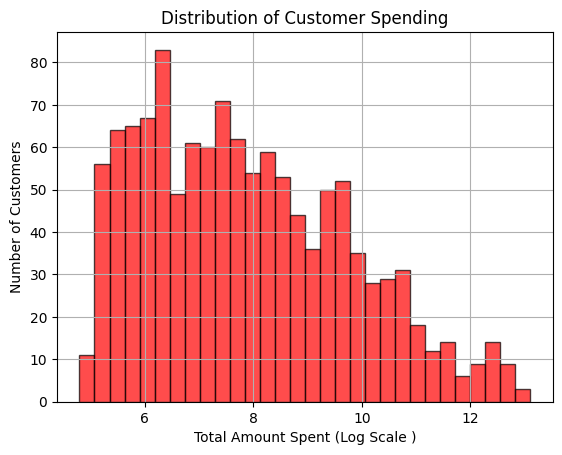

In [ ]:
#Who is the Lowest and Highest Spender?
spend_min = spend_sum.min()
spend_max = spend_sum.max()
print('min:' ,spend_min)
print('max:',spend_max)


#there are extreme outliers...remove top 1%
filtered_spend_sum = spend_sum[spend_sum < spend_sum.quantile(0.99)]

#very right skwewed because of the additional outliers. log transfromation to adjust
np.log1p(filtered_spend_sum).hist(bins=30, color='red', alpha=0.7, edgecolor='black')
plt.xlabel("Total Amount Spent (Log Scale )")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Spending")

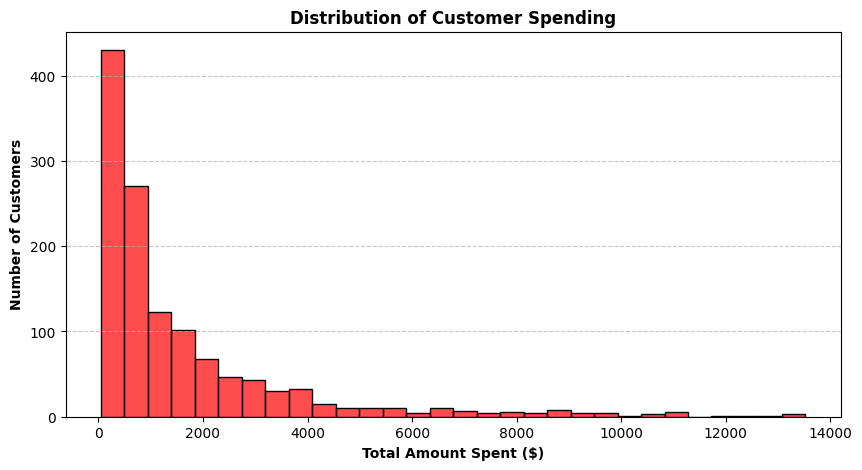

,Metric,Amount ($)
0,Minimum Spent,47.7800
1,Median Spent,786.5350
2,90th Percentile,4057.1420
3,99th Percentile,13555.3574
4,Maximum Spent,52414.5300


In [ ]:
# Calculate total spend per customer
customer_spend = trans_details.groupby('Customer_ID')['Total_Price'].sum().reset_index()
customer_spend.columns = ['Customer_ID', 'Total_Spent']

# Filter out extreme outliers (top 1% high spenders)
upper_limit = customer_spend['Total_Spent'].quantile(0.99)
filtered_spend = customer_spend[customer_spend['Total_Spent'] < upper_limit]

# Plot histogram of total spending
plt.figure(figsize=(10,5))
sns.histplot(filtered_spend['Total_Spent'], bins=30, color='red', edgecolor='black', alpha=0.7)
plt.xlabel("Total Amount Spent ($)", fontweight ='bold')
plt.ylabel("Number of Customers", fontweight ='bold')
plt.title("Distribution of Customer Spending", fontweight ='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Display high-value and low-value customer summary
spending_summary = pd.DataFrame({
    "Metric": ["Minimum Spent", "Median Spent", "90th Percentile", "99th Percentile", "Maximum Spent"],
    "Amount ($)": [
        customer_spend['Total_Spent'].min(),
        customer_spend['Total_Spent'].median(),
        customer_spend['Total_Spent'].quantile(0.90),
        customer_spend['Total_Spent'].quantile(0.99),
        customer_spend['Total_Spent'].max()
    ]
})

display(spending_summary)

 ### Log Scale Spending Breakdown (open up the markdown to view properly)

| Log Value | Lower Bound ($) | Upper Bound ($) |
|-----------|----------------|----------------|
| 5         | $148           | $402           |
| 6         | $403           | $1,095         |
| 7         | $1,096         | $2,979         |
| 8         | $2,980         | $8,102         |
| 9         | $8,103         | $22,025        |
| 10        | $22,026        | $59,873        |
| 11        | $59,874        | $162,753       |
| 12        | $162,754       | $442,412       |
| 13        | $442,413       | $1,000,000+    |


### Customers who purchased once vs multiple times

In [ ]:
# Group by Customer_ID and count occurrences
order_counts = df['Customer_ID'].value_counts()

# Customers who ordered only once
single_order_customers = order_counts[order_counts == 1]

# Customers who ordered multiple times
multiple_order_customers = order_counts[order_counts > 1]

# Display results
print(f"Customers who ordered only once: {len(single_order_customers)}")
print(f"Customers who ordered multiple times: {len(multiple_order_customers)}")

Customers who ordered only once: 372
Customers who ordered multiple times: 846


In [ ]:
# Remove shipping costs (blank SKU)
trans_details_clean = trans_details_clean.dropna(subset=['SKU'])

# Rename columns for clarity
trans_details_clean.rename(columns={
    'Product variant SKU': 'SKU',
    'Product type': 'Category',
    'Order name': 'Order_Num',
    'Customer ID': 'Customer_ID',
    'Product title': 'Product_Name',
    'Quantity ordered': 'Quantity',
    'Total sales': 'Total_Price',
    'Day': 'Order_Date'}, inplace=True)

# Convert Order_Date to datetime
trans_details_clean['Order_Date'] = pd.to_datetime(trans_details_clean['Order_Date'])

# Remove cancelled or test orders (Total_Price <= 0)
trans_details_clean = trans_details_clean[trans_details_clean['Total_Price'] > 0]

# Remove orders with 0 quantity
trans_details_clean = trans_details_clean[trans_details_clean['Quantity'] > 0]

# Fill missing categories with 'Other'
trans_details_clean['Category'] = trans_details_clean['Category'].fillna('Other')

# Verify cleaned data
trans_details_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5944 entries, 0 to 5943
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order_Date    5944 non-null   datetime64[ns]
 1   Customer_ID   5944 non-null   int64         
 2   Order_Num     5944 non-null   int64         
 3   Product_Name  5944 non-null   object        
 4   SKU           5944 non-null   object        
 5   Category      5944 non-null   object        
 6   Quantity      5944 non-null   int64         
 7   Total_Price   5944 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 371.6+ KB


## Customer Type Distrubition
76% of our customer base is considered Level 1 or Non-Priority Access, 23% is Priority Access.

Level 1/3 Customers have a transaction count capped at around 10-12. The spend is spread fairly evenly across customers with few going beyond log10 (4.5). There is less variations which can suggest these are more transactional spends and less loyal spending.

Prioirty Access Customers have more spread in the transaction count, going over 60. Many still cluster around the lower transaction counts but have very high spending. This shows that our Priority Access customers have more portential for high lifetime value and consistent reordering.



In [ ]:
df.columns

Index(['Order_Num', 'Order_Date', 'Prev_Order_Date', 'Days_Between_Orders',
       'Customer_ID', 'First_Name', 'Last_Name', 'Email', 'Email_Domain',
       'Customer_Type', 'State', 'Zip_Code', 'SKU', 'Category', 'Quantity',
       'Total_Price', 'Total_Amt_Spent', 'Total_Orders', 'Day_of_Month',
       'Month', 'Quarter'],
      dtype='object')

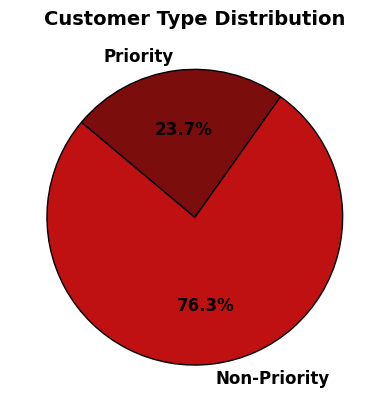

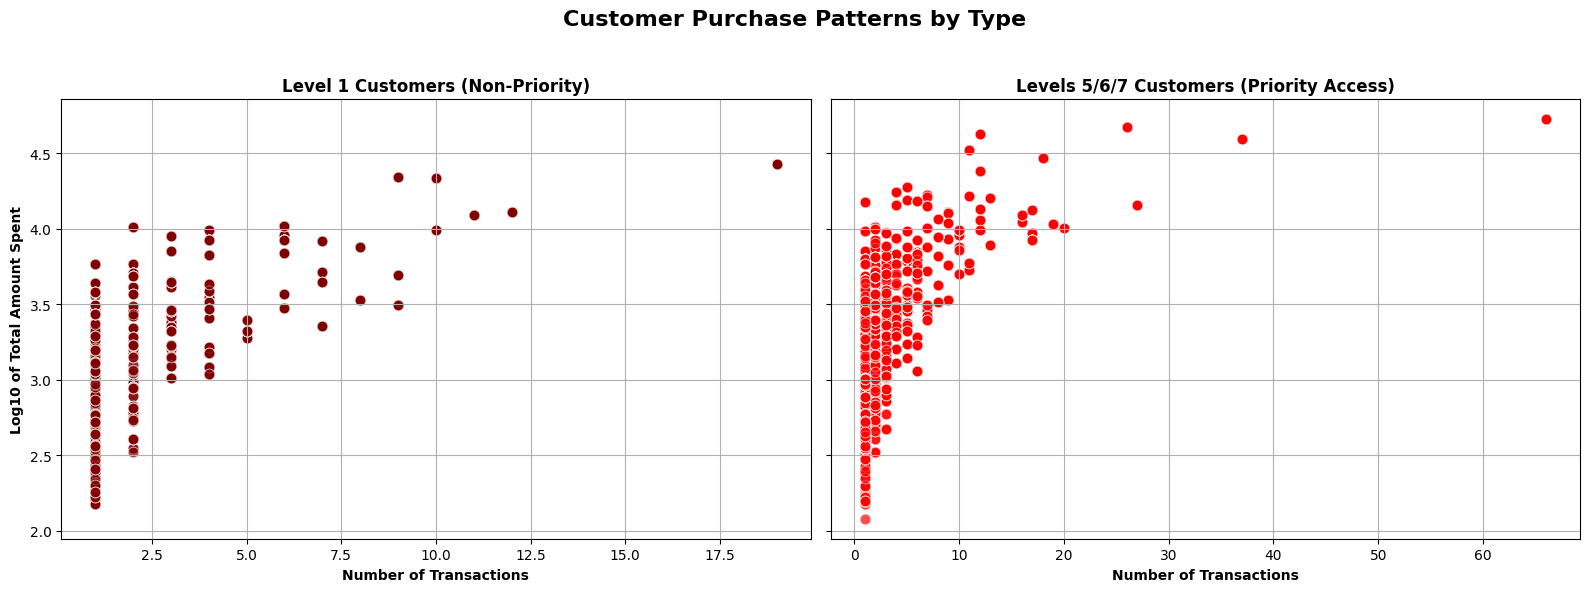

In [ ]:
#scatter plot - log scale amount spent on y axis, no trans on x axis, each do a customer (priority v non prioirty)- use different colors based on "levels 5/6/7" and see how far they are scattered.  see 1st graph

#number of priority (1) vs nonpriority access (0)
Customer_Type = df['Customer_Type'].value_counts()
labels = ['Non-Priority', 'Priority']
plt.pie(Customer_Type, labels = labels,
autopct='%1.1f%%', colors=red_shades, startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'color': 'black', 'fontsize': 12, 'weight': 'bold'})
plt.title("Customer Type Distribution", fontsize=14, fontweight = 'bold', color = 'black', loc ='center')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
plt.savefig('customer_type.png',transparent=True)
plt.show()


#scatter plot of amount spent vs number of transactions

# Split data by Customer_Type
df_priority = df[df['Customer_Type'] == 1]
df_non_priority = df[df['Customer_Type'] == 0]

# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for Non-Priority customers
sns.scatterplot(
    data=df_non_priority,
    x='Total_Orders',
    y=np.log10(df_non_priority['Total_Amt_Spent']),
    alpha=0.7,
    s=60,
    ax=axs[0],
    color = 'maroon'
)
axs[0].set_title('Level 1 Customers (Non-Priority)', fontweight='bold')
axs[0].set_xlabel('Number of Transactions', fontweight='bold')
axs[0].set_ylabel('Log10 of Total Amount Spent', fontweight='bold')
axs[0].grid(True)

# Plot for Priority Access customers
sns.scatterplot(
    data=df_priority,
    x='Total_Orders',
    y=np.log10(df_priority['Total_Amt_Spent']),
    alpha=0.7,
    s=60,
    ax=axs[1],
    color = 'red'
)
axs[1].set_title('Levels 5/6/7 Customers (Priority Access)', fontweight='bold')
axs[1].set_xlabel('Number of Transactions', fontweight='bold')
axs[1].grid(True)

plt.suptitle('Customer Purchase Patterns by Type', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Purchase Consistency Score

### Can we create a purchase consistency score to measure regularity in buying patterns?

The high frequency of customers that only purchase is high enough to consider looking into better retention strategies.

Outliers Identified:

Some customers buy way more frequently than expected, possibly due to bulk purchasing needs.Others have unexpected gaps between purchases, which could indicate seasonal demand shifts.

Analysis Description:

Order Frequency = Number of unique purchase days per customer (from Order_Date in trans_details)

Counted how many times each customer made a purchase.

Grouped customers into three categories based on how often they buy:

*   1 → Purchased once
*   2 → Multiple times a month (weekly)
*   3 → Multiple times a week (4+ times a month)


<ipython-input-119-23d4c08dab05>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_summary, x='Purchase Consistency Score', y='Customer Count', palette="Reds_r")


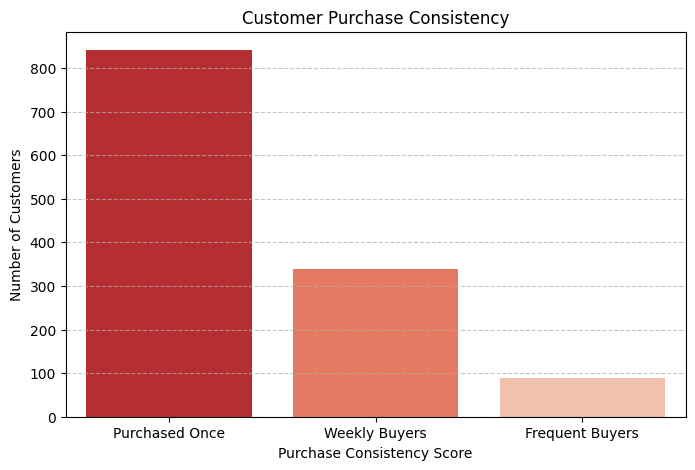

,Purchase Consistency Score,Customer Count
0,1,841
1,2,338
2,3,89


In [ ]:
# Aggregate order frequency per customer
customer_order_counts = trans_details.groupby('Customer_ID')['Order_Date'].nunique().reset_index()
customer_order_counts.columns = ['Customer_ID', 'Order_Frequency']

# Define purchase consistency score
def assign_consistency_score(freq):
    if freq == 1:
        return 1  # Purchased once
    elif freq <= 4:
        return 2  # Multiple times a month (weekly)
    else:
        return 3  # Multiple times a week

customer_order_counts['Purchase_Consistency_Score'] = customer_order_counts['Order_Frequency'].apply(assign_consistency_score)

# Detect outliers using IQR method
Q1 = customer_order_counts['Order_Frequency'].quantile(0.25)
Q3 = customer_order_counts['Order_Frequency'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

customer_order_counts['Outlier'] = (customer_order_counts['Order_Frequency'] < lower_bound) | (customer_order_counts['Order_Frequency'] > upper_bound)

# Count the number of customers in each purchase consistency category
purchase_summary = customer_order_counts.groupby('Purchase_Consistency_Score')['Customer_ID'].count().reset_index()
purchase_summary.columns = ['Purchase Consistency Score', 'Customer Count']

# Bar chart for purchase consistency
plt.figure(figsize=(8,5))
sns.barplot(data=purchase_summary, x='Purchase Consistency Score', y='Customer Count', palette="Reds_r")
plt.xticks([0, 1, 2], ["Purchased Once", "Weekly Buyers", "Frequent Buyers"])
plt.xlabel("Purchase Consistency Score")
plt.ylabel("Number of Customers")
plt.title("Customer Purchase Consistency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(purchase_summary)

## Big Spenders vs. Loyal Shoppers



###Which Customers Contribute the Highest Revenue vs. Most Frequent Purchases?

A small group of customers account for a large share of total revenue. These high-value customers spend significantly more per order.

Some customers purchase often but with smaller order amounts, while others buy less frequently but spend large amounts when they do.

Analysis Description:
Total Revenue Per Customer = Sum of Total_Price for each Customer_ID (from trans_details).
Total Orders Per Customer = Count of Order_Num for each Customer_ID.
Identified top customers based on:
1.  Highest Total Revenue (biggest spenders)
2. Most Frequent Orders (repeat buyers)
This helps in targeting VIP customers, optimizing loyalty programs, and understanding whether revenue comes from repeat buyers or high-ticket purchases.



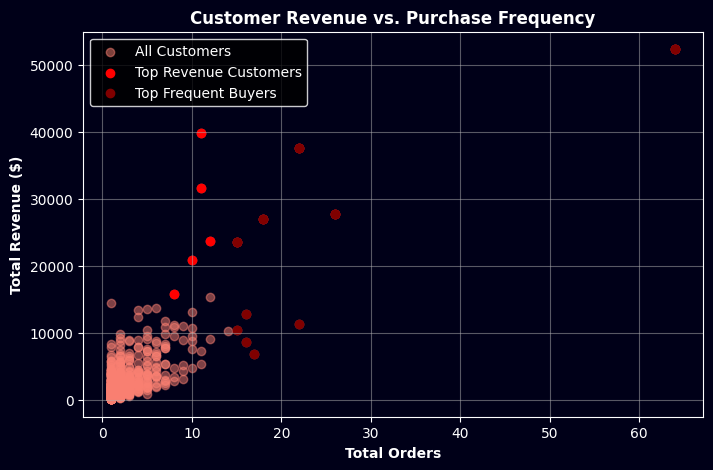

,Customer_ID,Total_Revenue,Total_Orders
883,7528879947927,52414.53,64
3,7110840123543,39843.43,11
2,7110686802071,37620.85,22
455,7356897034391,31659.98,11
552,7413647900823,27785.36,26
37,7126195503255,27083.12,18
412,7339669520535,23652.84,12
410,7339556274327,23546.56,15
492,7378394677399,20952.29,10
81,7140568694935,15839.90,8


,Customer_ID,Total_Revenue,Total_Orders
883,7528879947927,52414.53,64
552,7413647900823,27785.36,26
2,7110686802071,37620.85,22
464,7363956179095,11261.79,22
37,7126195503255,27083.12,18
175,7194331218071,6881.16,17
54,7128715395223,12752.40,16
101,7146096885911,8651.44,16
12,7117588758679,10395.33,15
410,7339556274327,23546.56,15


In [ ]:
# Calculate total revenue per customer
customer_revenue = trans_details.groupby('Customer_ID')['Total_Price'].sum().reset_index()
customer_revenue.columns = ['Customer_ID', 'Total_Revenue']

# Calculate total orders per customer
customer_orders = trans_details.groupby('Customer_ID')['Order_Num'].nunique().reset_index()
customer_orders.columns = ['Customer_ID', 'Total_Orders']

# Merge both metrics
customer_summary = pd.merge(customer_revenue, customer_orders, on='Customer_ID')

# Get top customers by revenue
top_revenue_customers = customer_summary.nlargest(10, 'Total_Revenue')

# Get top customers by order frequency
top_order_customers = customer_summary.nlargest(10, 'Total_Orders')

# Scatter plot: Revenue vs. Orders with distinctive blue shades
plt.figure(figsize=(8,5), facecolor='#000018')

# General customers (lighter red)
plt.scatter(customer_summary['Total_Orders'], customer_summary['Total_Revenue'],
            alpha=0.5, color='salmon', label="All Customers")

# Highlight top 10 revenue customers (medium red)
plt.scatter(top_revenue_customers['Total_Orders'], top_revenue_customers['Total_Revenue'],
            color='red', label="Top Revenue Customers")

# Highlight top 10 frequent buyers (dark red)
plt.scatter(top_order_customers['Total_Orders'], top_order_customers['Total_Revenue'],
            color='maroon', label="Top Frequent Buyers")

# Formatting
plt.xlabel("Total Orders",color = 'white', fontweight = 'bold')
plt.tick_params(axis='x', colors='white')
plt.ylabel("Total Revenue ($)", color = 'white', fontweight = 'bold')
plt.tick_params(axis='y', colors='white')
plt.title("Customer Revenue vs. Purchase Frequency",color='white',fontweight='bold')
plt.grid(alpha=0.5)
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

# Display top customers
display(top_revenue_customers)
display(top_order_customers)



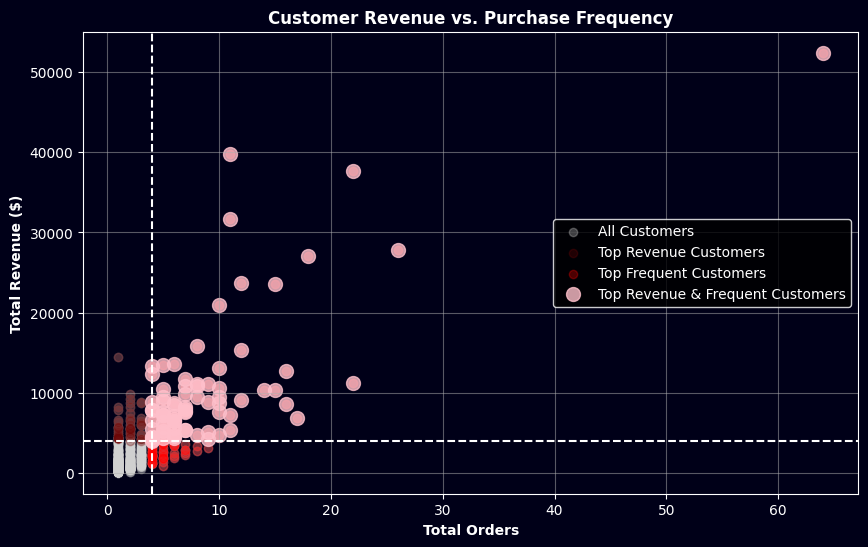

,Customer_ID,Total_Revenue,Total_Orders
2,7110686802071,37620.85,22
3,7110840123543,39843.43,11
4,7116133302423,4658.39,6
11,7117402341527,8710.19,6
12,7117588758679,10395.33,15
...,...,...,...
1127,7715172286615,4501.47,2
1153,7746337439895,6500.40,2
1164,7755407917207,8277.18,1
1167,7759763439767,4394.14,1


,Customer_ID,Total_Revenue,Total_Orders
2,7110686802071,37620.85,22
3,7110840123543,39843.43,11
4,7116133302423,4658.39,6
5,7116199461015,3618.67,7
8,7116380176535,1891.92,5
...,...,...,...
907,7542294020247,2062.90,4
909,7542483419287,2293.97,4
921,7550770839703,6415.19,5
944,7580772204695,5465.86,4


,Customer_ID,Total_Revenue_x,Total_Orders_x,Total_Revenue_y,Total_Orders_y
0,7110686802071,37620.85,22,37620.85,22
1,7110840123543,39843.43,11,39843.43,11
2,7116133302423,4658.39,6,4658.39,6
3,7117402341527,8710.19,6,8710.19,6
4,7117588758679,10395.33,15,10395.33,15
...,...,...,...,...,...
72,7473959698583,5225.99,5,5225.99,5
73,7483523399831,5724.02,5,5724.02,5
74,7528879947927,52414.53,64,52414.53,64
75,7550770839703,6415.19,5,6415.19,5


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Calculate total revenue per customer
customer_revenue = trans_details.groupby('Customer_ID')['Total_Price'].sum().reset_index()
customer_revenue.columns = ['Customer_ID', 'Total_Revenue']

# Calculate total orders per customer
customer_orders = trans_details.groupby('Customer_ID')['Order_Num'].nunique().reset_index()
customer_orders.columns = ['Customer_ID', 'Total_Orders']

# Merge both metrics
customer_summary = pd.merge(customer_revenue, customer_orders, on='Customer_ID')

# Calculate 90th percentile thresholds
revenue_threshold = customer_summary['Total_Revenue'].quantile(0.9)
orders_threshold = customer_summary['Total_Orders'].quantile(0.9)

# Identify top customers
top_revenue_customers = customer_summary[customer_summary['Total_Revenue'] >= revenue_threshold]
top_order_customers = customer_summary[customer_summary['Total_Orders'] >= orders_threshold]

# Identify customers who are both top revenue and top frequency
top_both_customers = pd.merge(top_revenue_customers, top_order_customers, on='Customer_ID')


# Scatter plot
plt.figure(figsize=(10,6), facecolor='#000018')

# Plot all customers
plt.scatter(customer_summary['Total_Orders'], customer_summary['Total_Revenue'],
            alpha=0.3, color='lightgrey', label="All Customers")

# Highlight top revenue customers
plt.scatter(top_revenue_customers['Total_Orders'], top_revenue_customers['Total_Revenue'],alpha=0.3,
            color='#6d0606', label="Top Revenue Customers")

# Highlight top frequent customers
plt.scatter(top_order_customers['Total_Orders'], top_order_customers['Total_Revenue'],alpha=0.3,
            color='red', label="Top Frequent Customers")

# Highlight customers who are top in both revenue and frequency
plt.scatter(top_both_customers['Total_Orders_x'], top_both_customers['Total_Revenue_x'],alpha=0.8,
            color='pink', s=100, label="Top Revenue & Frequent Customers")

# Add threshold lines
plt.axhline(y=revenue_threshold, color='white', linestyle='--')
plt.axvline(x=orders_threshold, color='white', linestyle='--')

# Formatting
plt.xlabel("Total Orders", color='white', fontweight='bold')
plt.ylabel("Total Revenue ($)", color='white', fontweight='bold')
plt.title("Customer Revenue vs. Purchase Frequency", color='white', fontweight='bold')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.grid(alpha=0.5)

ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.show()

# Display tables
display(top_revenue_customers)
display(top_order_customers)
display(top_both_customers)


## Customer Repurchase Distribution

###What Percentage of Customers Repurchase Within 30 Days, 60 Days, or Longer?

A large percentage of customers do not make a second purchase within 30 or 60 days. This suggests that many buyers may be one-time purchasers or have longer purchase cycles.

Analysis Description:

Days Between Orders = Difference between Order_Date and the previous purchase date for each Customer_ID.

Counted how many customers repurchased within 30 days, 60 days, or later.
Categorized customers into three groups:

* 30 Days → Customers who repurchased within a month
* 60 Days → Customers who repurchased between 31-60 days
* Longer → Customers who repurchased after 60+ days

This helps analyze customer retention, determine optimal remarketing timing, and identify which segments have longer buying cycles.

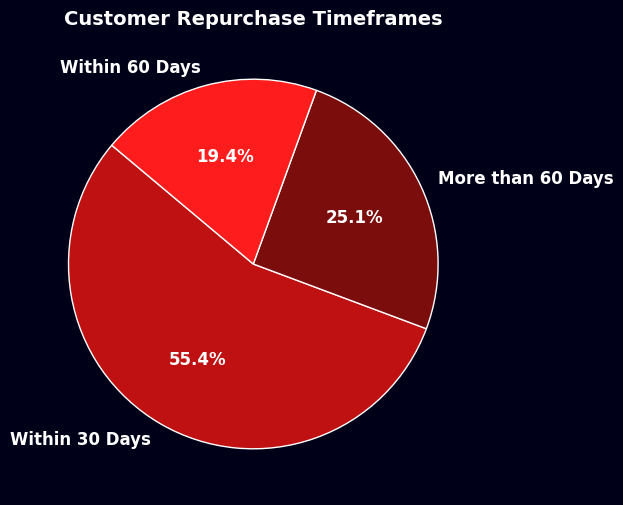

,Repurchase Timeframe,Percentage
0,Within 30 Days,55.41347
1,More than 60 Days,25.14919
2,Within 60 Days,19.43734


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Ensure Order_Date is datetime format
trans_details['Order_Date'] = pd.to_datetime(trans_details['Order_Date'])

# Sort by Customer_ID and Order_Date
trans_details = trans_details.sort_values(by=['Customer_ID', 'Order_Date'])

# Calculate days between consecutive orders for each customer
trans_details['Prev_Order_Date'] = trans_details.groupby('Customer_ID')['Order_Date'].shift(1)
trans_details['Days_Between_Orders'] = (trans_details['Order_Date'] - trans_details['Prev_Order_Date']).dt.days

repurchase_data = trans_details.dropna(subset=['Days_Between_Orders']).copy()

# Categorize repurchase timeframes
repurchase_data.loc[:, 'Repurchase_Category'] = pd.cut(
    repurchase_data['Days_Between_Orders'],
    bins=[0, 30, 60, float('inf')],
    labels=['Within 30 Days', 'Within 60 Days', 'More than 60 Days']
)

# Count percentage of customers in each category
repurchase_summary = repurchase_data['Repurchase_Category'].value_counts(normalize=True) * 100
repurchase_summary = repurchase_summary.reset_index()
repurchase_summary.columns = ['Repurchase Timeframe', 'Percentage']

red_shades = ['#bf1111', '#7c0d0d', '#ff1c1c']  # Different shades of red

plt.figure(figsize=(6,6),facecolor='#000018')
plt.pie(repurchase_summary['Percentage'], labels=repurchase_summary['Repurchase Timeframe'],
        autopct='%1.1f%%', colors=red_shades, startangle=140, wedgeprops={'edgecolor': 'white'}, textprops={'color': 'white', 'fontsize': 12, 'weight': 'bold'}
)
plt.title("Customer Repurchase Timeframes", fontsize=14, fontweight = 'bold', color = 'white', loc ='center')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

display(repurchase_summary)


## Time Based Analysis

###Seasonal Patterns of Customer Spending

Customers may follow a monthly purchasing cycle, with spikes on predictable days such as the end of the month, orders, which are slightly elevated, suggesting that some customers finalize purchases before month-end deadlines. Orders show a gradual increase from February through September. June through October maintains strong order volume, with the highest activity in September and October (both exceeding 700 orders). There is a notable drop in November, likely due to seasonal slowdowns or budget constraints. Orders partially recover in December, possibly due to end-of-year purchasing or companies finalizing budgets. Q1 (Jan-Mar) is the slowest, suggesting a seasonal dip. Q1 (Jan-Mar) has the lowest order volume, staying below 800 orders. This is because EPA switched from one website domain to another with a lack of promotional awareness and SEO strategy to their customers and had not begun to push for an online initiative. Q3 (Jul-Sep) is the strongest quarter, peaking at 2,000 orders. This is aligned with EPA optimizing their ad spend on Google, increasing traffic to their website.

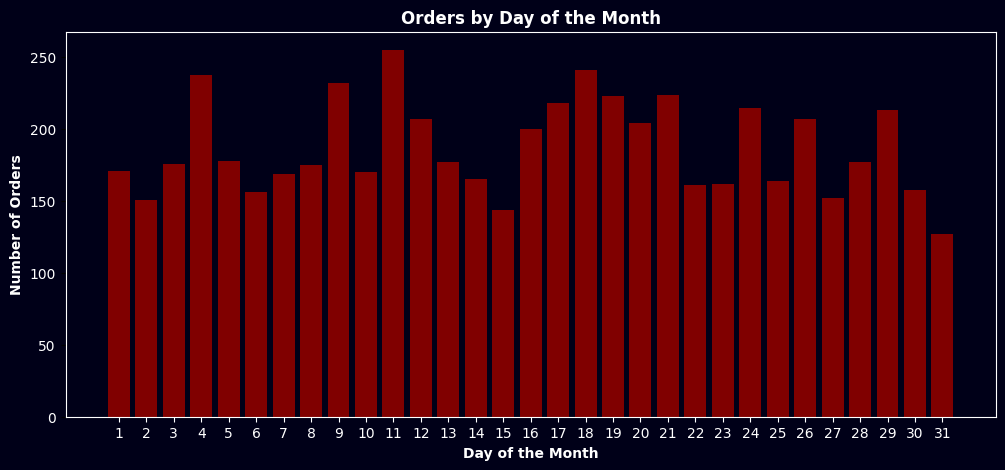

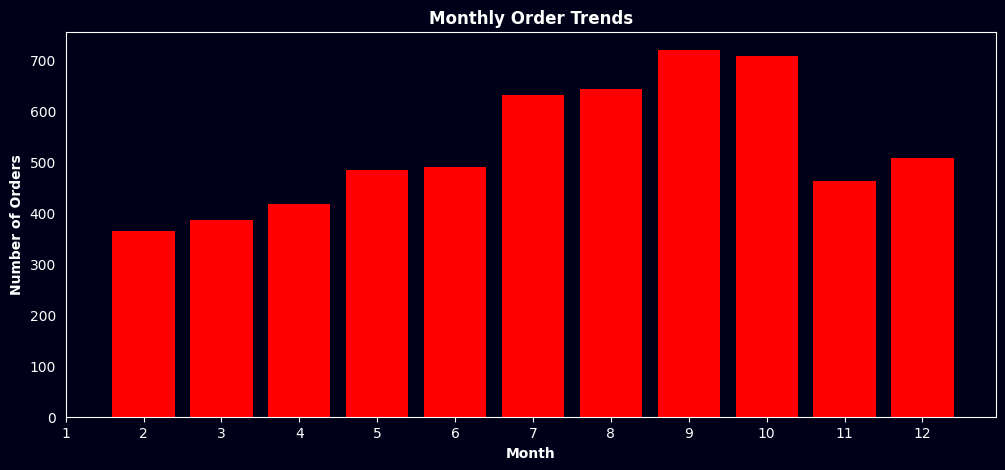

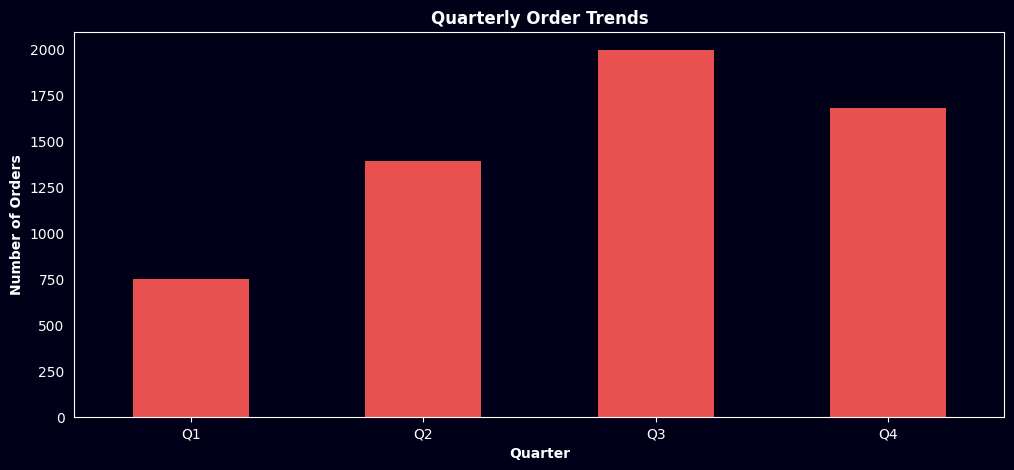

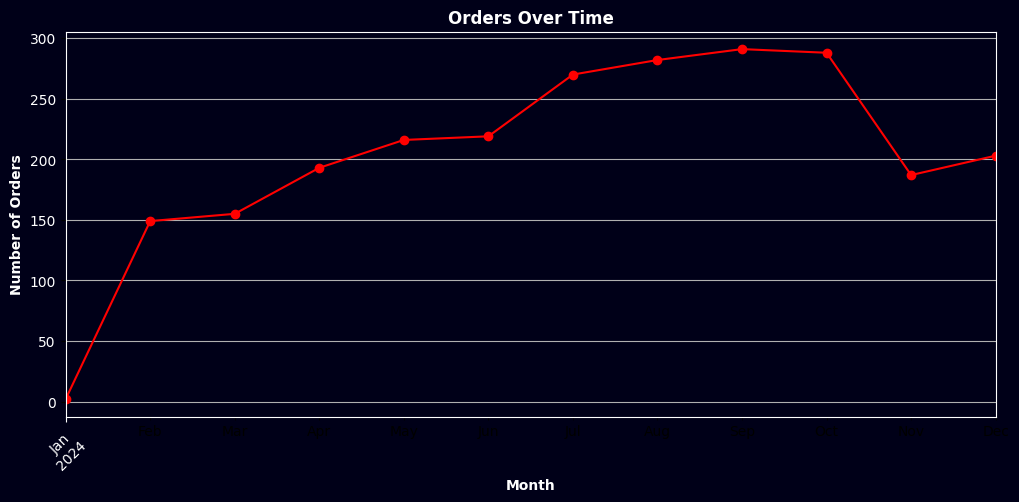

,0
Order_Date,
2024-01,2
2024-02,149
2024-03,155
2024-04,193
2024-05,216
2024-06,219
2024-07,270
2024-08,282
2024-09,291


In [ ]:
import matplotlib.pyplot as plt

# Extract time features
df['Day_of_Month'] = df['Order_Date'].dt.day
df['Month'] = df['Order_Date'].dt.month
df['Quarter'] = df['Order_Date'].dt.to_period('Q')

# Grouping orders by different time periods
orders_by_day = df.groupby('Day_of_Month').size()
orders_by_month = df.groupby('Month').size()
orders_by_quarter = df.groupby('Quarter').size()

# Plot Orders by Day of the Month
plt.figure(figsize=(12, 5),facecolor='#000018')
plt.bar(orders_by_day.index, orders_by_day.values, color='maroon')
plt.xlabel("Day of the Month", fontweight ='bold', color = 'white')
plt.ylabel("Number of Orders", fontweight ='bold',color='white')
plt.title("Orders by Day of the Month", fontweight ='bold',color='white')
plt.xticks(range(1, 32))  # Show all days

ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
  plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

# Plot Orders by Month
plt.figure(figsize=(12, 5),facecolor='#000018')
plt.bar(orders_by_month.index, orders_by_month.values, color='red')
plt.xlabel("Month", fontweight ='bold',color='white')
plt.ylabel("Number of Orders", fontweight ='bold',color='white')
plt.title("Monthly Order Trends", fontweight ='bold',color='white')
plt.xticks(range(1, 13))  # Show all months

ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
  plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

# Plot Orders by Quarter
orders_by_quarter.index = orders_by_quarter.index.astype(str).str[-2:]  # Extract last two characters (Q1, Q2, etc.)

plt.figure(figsize=(12, 5),facecolor='#000018')
orders_by_quarter.plot(kind='bar', color='#e95050')
plt.xlabel("Quarter", fontweight ='bold',color='white')
plt.xticks(rotation=0)
plt.ylabel("Number of Orders", fontweight ='bold',color='white')
plt.title("Quarterly Order Trends", fontweight ='bold',color='white')

ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
  plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

# Count number of orders per month
orders_over_time = transactions.groupby(transactions['Order_Date'].dt.to_period("M")).size()

# Plot order trends over time
plt.figure(figsize=(12, 5),facecolor='#000018')
orders_over_time.plot(marker='o', linestyle='-', color='red')
plt.xlabel("Month", fontweight ='bold',color='white')
plt.yticks(color = 'white')
plt.tick_params(axis='x', colors='white')
plt.ylabel("Number of Orders", fontweight ='bold',color='white')
plt.title("Orders Over Time", fontweight ='bold',color='white')
plt.grid(axis='y')
plt.xticks(rotation=45,color='white')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
  plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

# Display order count trends
orders_over_time


##Product Analysis

The sales distribution is highly skewed, meaning a small number of SKUs drive the majority of sales. The top 3 SKUs contribute significantly more to overall sales compared to the rest. Lower-ranked SKUs in the top 10 list still have meaningful sales, but there is a visible gap between them and the top-tier products.

In [ ]:
top_selling_products = trans_details.groupby('SKU').agg(
    total_units_sold=('Quantity', 'sum'),
    total_revenue=('Total_Price', 'sum')
).reset_index()

# Sort by highest and lowest sales
top_selling_products = top_selling_products.sort_values(by='total_units_sold', ascending=False)

# Display Top 10 Selling Products
print("Top 10 Selling Products:")
print(top_selling_products.head(10))

# Display Bottom 10 Selling Products
print("\nBottom 10 Selling Products:")
print(top_selling_products.tail(10))

top_10 = top_selling_products.head(10)
bottom_10 = top_selling_products.tail(10)

Top 10 Selling Products:
                 SKU  total_units_sold  total_revenue
1230  SUP04-068-125-              1690       11824.50
257    GUZ04-070-125              1359       10881.54
255    GUZ04-060-125               714        4999.22
75    CAGE 4568G-9GA               500       13647.09
39             C QC8               417       10917.97
54             C RL8               348        8211.09
73    CAGE 4558G-9GA               334        8029.86
532           JMEP16               313        5906.86
538          JMLP16-               293        4124.95
339         H TAIL3K               274       10619.21

Bottom 10 Selling Products:
                   SKU  total_units_sold  total_revenue
713       N 16CC816KIT                 1        3614.04
712   N 16BD08-8020RJK                 1        2499.14
711      N 16BD06-8020                 1        2449.64
709             N 16BB                 1         699.99
708        N 16AX8025-                 1         784.34
1016         PP0

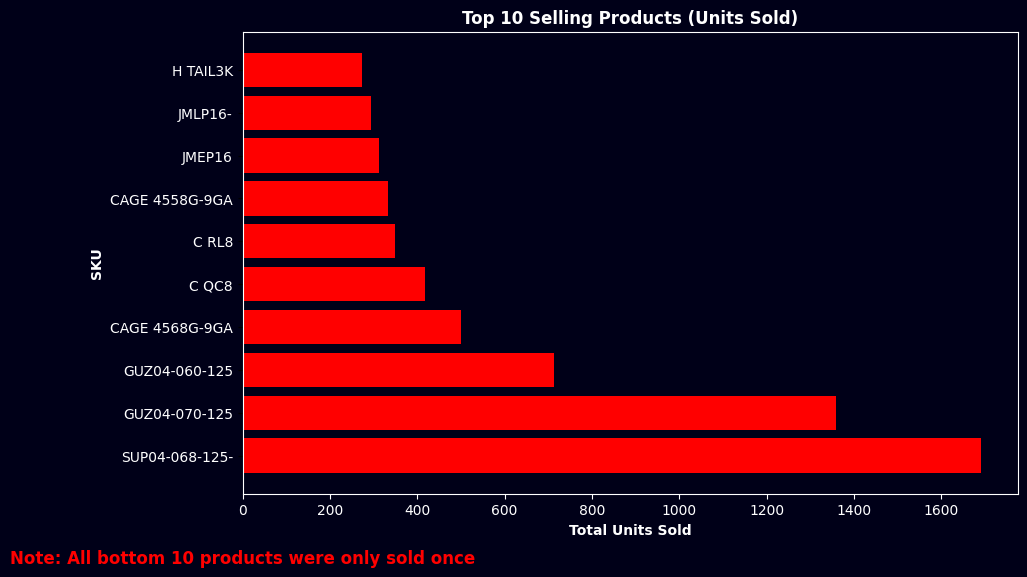

In [ ]:
#top 10 products
#revenue_per_unit = total_revenue / total_units_sold



plt.figure(figsize=(10, 6), facecolor='#000018')
plt.barh(top_10['SKU'], top_10['total_units_sold'], color='Red')
plt.xlabel('Total Units Sold', fontweight='bold',color='white')
plt.ylabel('SKU', fontweight='bold', color = 'white')
plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
plt.title('Top 10 Selling Products (Units Sold)', fontweight='bold', color='white')
plt.annotate(
    'Note: All bottom 10 products were only sold once',
    xy=(0, -0.15),  # Position (left side, below x-axis)
    xycoords='axes fraction',
    ha='center', fontsize=12, color='Red', fontweight='bold')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')


plt.show()

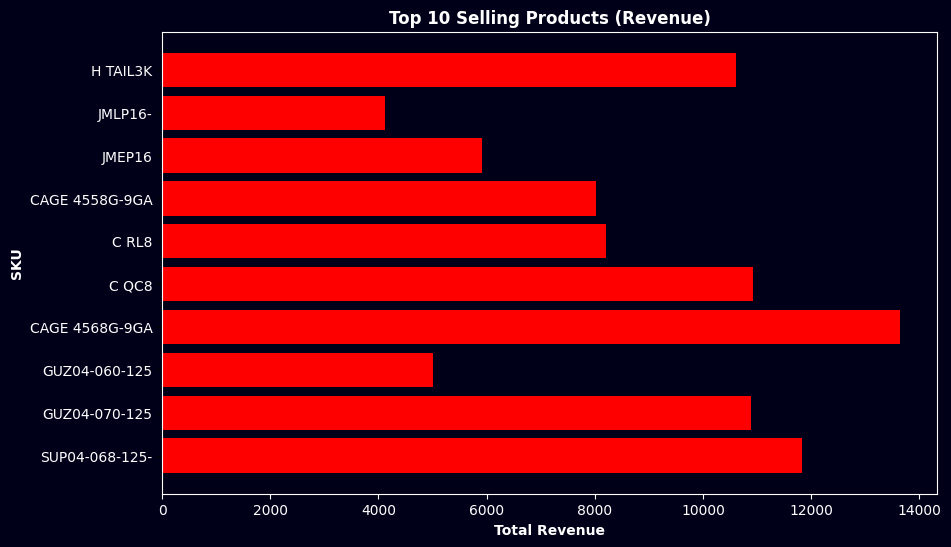

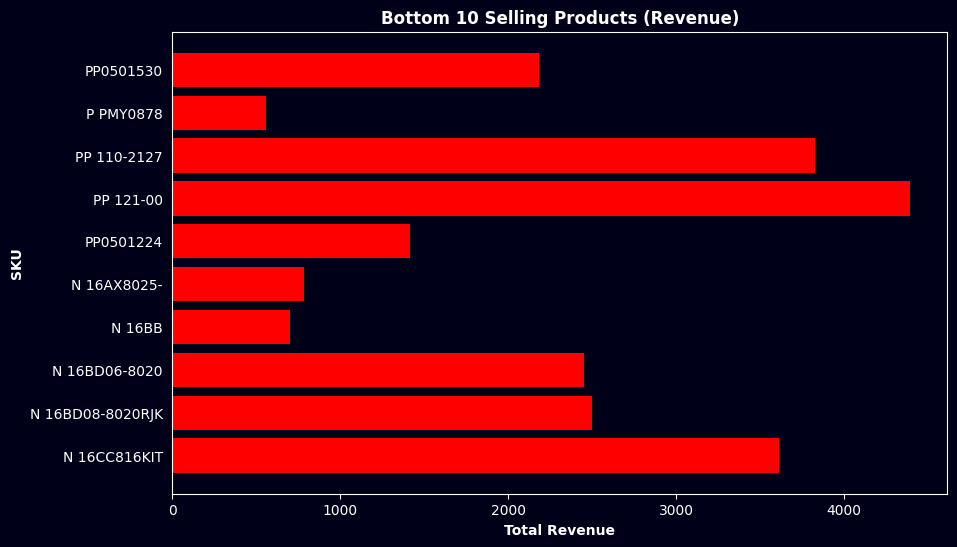

In [ ]:
#top 10 v bottom 10 products by revenue
plt.figure(figsize=(10, 6),facecolor='#000018')
plt.barh(top_10['SKU'], top_10['total_revenue'], color='red')
plt.xlabel('Total Revenue', fontweight='bold', color ='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.tick_params(axis='x', colors='white')
plt.ylabel('SKU', fontweight='bold', color ='white')
plt.title('Top 10 Selling Products (Revenue)', fontweight='bold', color ='white')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

plt.figure(figsize=(10, 6),facecolor='#000018')
plt.barh(bottom_10['SKU'], bottom_10['total_revenue'], color='red')
plt.xlabel('Total Revenue', fontweight='bold', color ='white')
plt.xticks(color='white')
plt.tick_params(axis='x', colors='white')
plt.yticks(color='white')
plt.ylabel('SKU', fontweight='bold', color ='white')
plt.title('Bottom 10 Selling Products (Revenue)', fontweight='bold', color ='white')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

In [ ]:
sku_reorders = trans_details.groupby('SKU').agg(
    total_customers=('Customer_ID', 'nunique'),  # Unique customers per SKU
    reorder_customers=('Customer_ID', lambda x: (x.value_counts() > 1).sum())  # Customers who reordered
).reset_index()

# Calculate reorder rate
sku_reorders['reorder_rate'] = (sku_reorders['reorder_customers'] / sku_reorders['total_customers']) * 100

never_reordered_products = sku_reorders[sku_reorders['reorder_customers'] == 0]


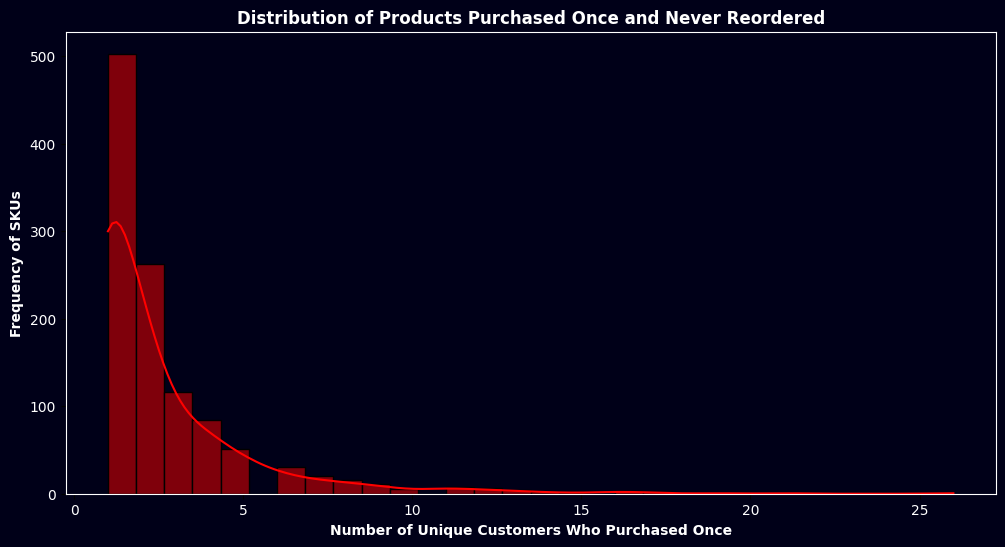

In [ ]:
#Identify products that were purchased once but never reordered.
never_reordered_products = (sku_reorders[sku_reorders['reorder_customers'] == 0])
never_reordered_products = never_reordered_products.sort_values(by='total_customers', ascending=False)

plt.figure(figsize=(12, 6),facecolor='#000018')
sns.histplot(never_reordered_products['total_customers'], bins=30, kde=True, color='red')

plt.xlabel("Number of Unique Customers Who Purchased Once",fontweight = 'bold',color='white')
plt.xticks(color='white')
plt.ylabel("Frequency of SKUs",fontweight = 'bold',color='white')
plt.yticks(color='white')
plt.title("Distribution of Products Purchased Once and Never Reordered",fontweight = 'bold',color = 'white')
ax = plt.gca()
ax.set_facecolor('#000018')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

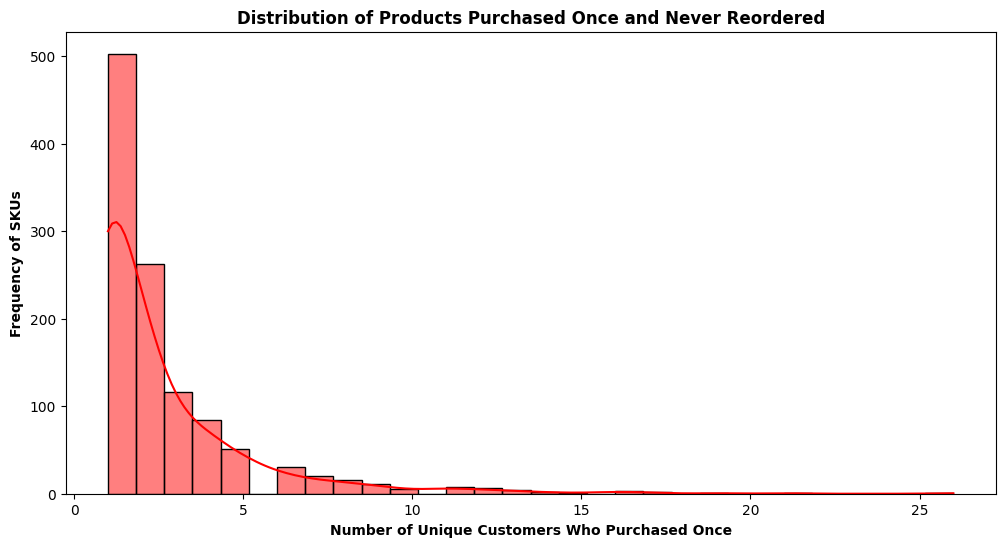

In [ ]:
#Identify products that were purchased once but never reordered.
never_reordered_products = (sku_reorders[sku_reorders['reorder_customers'] == 0])
never_reordered_products = never_reordered_products.sort_values(by='total_customers', ascending=False)

plt.figure(figsize=(12, 6))
sns.histplot(never_reordered_products['total_customers'], bins=30, kde=True, color='red')

plt.xlabel("Number of Unique Customers Who Purchased Once",fontweight = 'bold',color='black')
plt.xticks(color='black')
plt.ylabel("Frequency of SKUs",fontweight = 'bold',color='black')
plt.yticks(color='black')
plt.title("Distribution of Products Purchased Once and Never Reordered",fontweight = 'bold',color = 'black')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
plt.show()

#Predictive Modeling

The initial model includes K-Means Clustering to refine customer segmentation based on the Shopify data purchase behavior.

## K-Means Clustering

Initial model

In [ ]:
# Select specific columns for clustering
selected_features = ['Customer_Type', 'State', 'SKU', 'Category'] #do we need SKU and Category right now?
df_selected = df[selected_features]
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical columns (if any)
for col in df_selected.select_dtypes(include=['object']).columns:
    df_selected[col] = LabelEncoder().fit_transform(df_selected[col])

# Scale numeric columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

#proceed with K-Means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# View the results
print(df[['Cluster'] + selected_features])

<ipython-input-130-c5528873c95c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = LabelEncoder().fit_transform(df_selected[col])
<ipython-input-130-c5528873c95c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = LabelEncoder().fit_transform(df_selected[col])
<ipython-input-130-c5528873c95c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

      Cluster  Customer_Type State             SKU                    Category
1           2              1    FL        PW Q08FS  Vacuum Truck Hose Fittings
2           1              1    FL  HF-1002719-120            Hydro Excavation
3           0              1    WA         MH CTP5               Manhole Tools
4           2              1    FL       PW QD08MP  Vacuum Truck Hose Fittings
5           1              1    FL    PW 300680050            Hydro Excavation
...       ...            ...   ...             ...                         ...
5939        0              1    NY         BR A600  Vacuum Truck Hose Fittings
5940        0              1    NY    V 6HFHD-BARB  Vacuum Truck Hose Fittings
5941        1              1    FL      JHP1625600                 Jetter Hose
5942        1              1    FL     J SPHK-08TH                 Jetter Hose
5943        0              1    NY         BR G600          Vacuum Truck Parts

[5810 rows x 5 columns]


In [ ]:
# Select only numeric columns for aggregation
numeric_columns = df.select_dtypes(include=['number']).columns

# Aggregate the numeric columns
cluster_profiles = df.groupby('Cluster')[numeric_columns].agg(['mean', 'std'])
print(cluster_profiles)


        Days_Between_Orders            Customer_Type       Quantity  \
                       mean        std          mean  std      mean   
Cluster                                                               
0                  7.904248  25.835718           1.0  0.0  3.047516   
1                 10.029340  30.949012           1.0  0.0  2.220049   
2                  7.987918  26.080148           1.0  0.0  4.940299   
3                  9.723512  31.335554           0.0  0.0  2.536284   

                   Total_Price             Total_Amt_Spent                \
               std        mean         std            mean           std   
Cluster                                                                    
0         9.301578  366.970871  532.336114     9284.641310  15155.522291   
1         3.088974  443.486198  605.589993     5636.253276   7540.122477   
2        22.018080  391.950739  577.573848     8714.594463  11700.714115   
3         8.563093  368.573396  504.635669    

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical columns (if any)
for col in df_selected.select_dtypes(include=['object']).columns:
    df_selected[col] = LabelEncoder().fit_transform(df_selected[col])

# Scale numeric columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

#K-Means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# View the results
print(df[['Cluster'] + selected_features])


      Cluster  Customer_Type State             SKU                    Category
1           2              1    FL        PW Q08FS  Vacuum Truck Hose Fittings
2           1              1    FL  HF-1002719-120            Hydro Excavation
3           0              1    WA         MH CTP5               Manhole Tools
4           2              1    FL       PW QD08MP  Vacuum Truck Hose Fittings
5           1              1    FL    PW 300680050            Hydro Excavation
...       ...            ...   ...             ...                         ...
5939        0              1    NY         BR A600  Vacuum Truck Hose Fittings
5940        0              1    NY    V 6HFHD-BARB  Vacuum Truck Hose Fittings
5941        1              1    FL      JHP1625600                 Jetter Hose
5942        1              1    FL     J SPHK-08TH                 Jetter Hose
5943        0              1    NY         BR G600          Vacuum Truck Parts

[5810 rows x 5 columns]


In [ ]:
# Select only numeric columns for aggregation
numeric_columns = df.select_dtypes(include=['number']).columns

# Aggregate the numeric columns
cluster_profiles = df.groupby('Cluster')[numeric_columns].agg(['mean', 'std', 'min', 'max'])
print(cluster_profiles)

# For categorical columns, use 'mode' to get the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns

cluster_profiles_categorical = df.groupby('Cluster')[categorical_columns].agg(lambda x: x.mode()[0])
print(cluster_profiles_categorical)


categorical_columns = df.select_dtypes(include=['object']).columns


cluster_profiles_categorical = df.groupby('Cluster')[categorical_columns].agg(lambda x: x.mode()[0])
print(cluster_profiles_categorical)





        Days_Between_Orders                        Customer_Type            \
                       mean        std  min    max          mean       std   
Cluster                                                                      
0                  7.683219  25.571784  0.0  277.0      0.786530  0.409874   
1                 10.544214  31.689934  0.0  247.0      0.784102  0.411541   
2                  8.357660  28.043207  0.0  312.0      0.717909  0.450134   

                 Quantity             ... Day_of_Month         Month  \
        min max      mean        std  ...          min max      mean   
Cluster                               ...                              
0         0   1  2.921233   8.472791  ...            1  31  7.422374   
1         0   1  2.163688   2.863239  ...            1  31  7.484008   
2         0   1  4.447723  20.049211  ...            1  31  7.388199   

                          Cluster               
              std min max    mean  std min max  


In [ ]:
df.to_csv('Transactions Details.csv', index = False)

In [ ]:
grouped = df.groupby('Customer_ID')['Order_Date'].agg(['min', 'max']).reset_index()

# If the first and last order dates are the same, keep the same value for both columns
grouped['first_order_date'] = grouped.apply(lambda row: row['min'] if row['min'] == row['max'] else row['min'], axis=1)
grouped['last_order_date'] = grouped.apply(lambda row: row['max'] if row['min'] == row['max'] else row['max'], axis=1)

# Drop the original 'min' and 'max' columns
grouped = grouped.drop(columns=['min', 'max'])

# Display the result
print(grouped)

        Customer_ID first_order_date last_order_date
0     7110686802071       2024-03-21      2024-11-19
1     7110840123543       2024-02-05      2024-12-18
2     7116133302423       2024-02-05      2024-10-24
3     7116199461015       2024-02-05      2024-12-17
4     7116224757911       2024-05-29      2024-05-29
...             ...              ...             ...
1213  7872750780567       2024-12-29      2024-12-29
1214  7873460011159       2024-12-30      2024-12-30
1215  7873639252119       2024-12-30      2024-12-30
1216  7874198470807       2024-12-30      2024-12-30
1217  7875447750807       2024-12-31      2024-12-31

[1218 rows x 3 columns]


In [ ]:
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Aggregate numeric columns
numeric_agg = df.groupby('Cluster')[numeric_columns].agg(['mean', 'std'])

# Aggregate categorical columns (using mode)
categorical_agg = df.groupby('Cluster')[categorical_columns].agg(lambda x: x.mode()[0])

# Merge both results
cluster_profiles = pd.concat([numeric_agg, categorical_agg], axis=1)
print(cluster_profiles)


         (Days_Between_Orders, mean)  (Days_Between_Orders, std)  \
Cluster                                                            
0                           7.683219                   25.571784   
1                          10.544214                   31.689934   
2                           8.357660                   28.043207   

         (Customer_Type, mean)  (Customer_Type, std)  (Quantity, mean)  \
Cluster                                                                  
0                     0.786530              0.409874          2.921233   
1                     0.784102              0.411541          2.163688   
2                     0.717909              0.450134          4.447723   

         (Quantity, std)  (Total_Price, mean)  (Total_Price, std)  \
Cluster                                                             
0               8.472791           353.721821          505.877418   
1               2.863239           451.408495          602.976501   
2           

###Clustering Visualization

In [ ]:
df.columns

Index(['Order_Num', 'Order_Date', 'Prev_Order_Date', 'Days_Between_Orders',
       'Customer_ID', 'First_Name', 'Last_Name', 'Email', 'Email_Domain',
       'Customer_Type', 'State', 'Zip_Code', 'SKU', 'Category', 'Quantity',
       'Total_Price', 'Total_Amt_Spent', 'Total_Orders', 'Day_of_Month',
       'Month', 'Quarter', 'Cluster'],
      dtype='object')

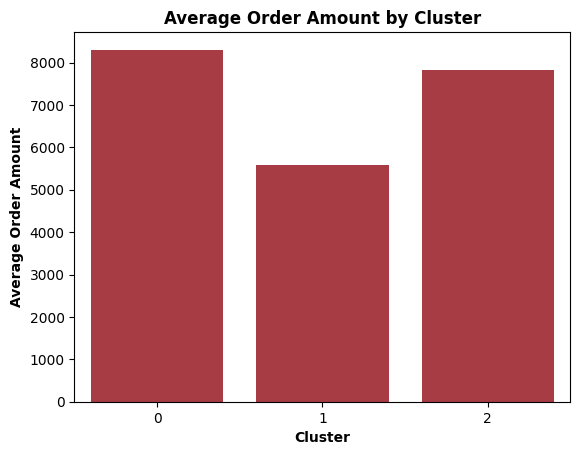

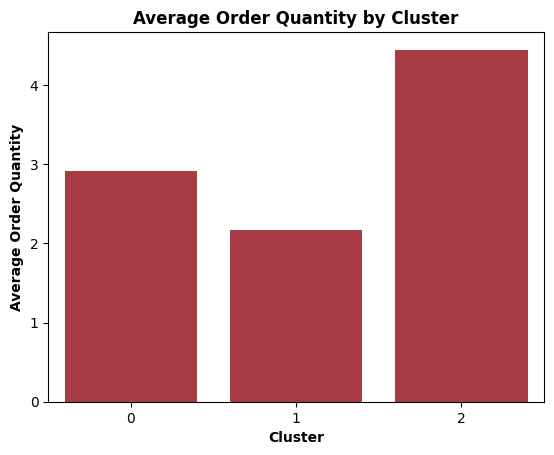

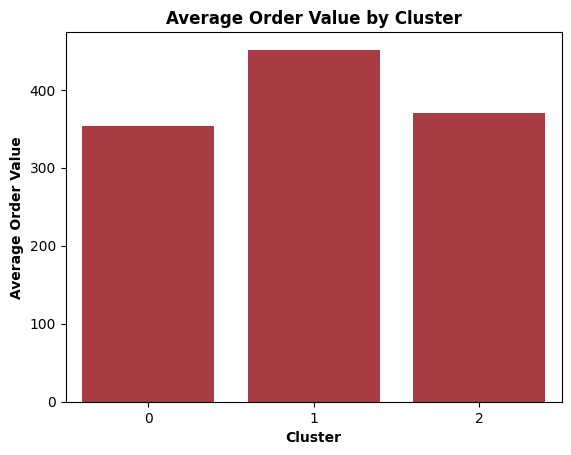

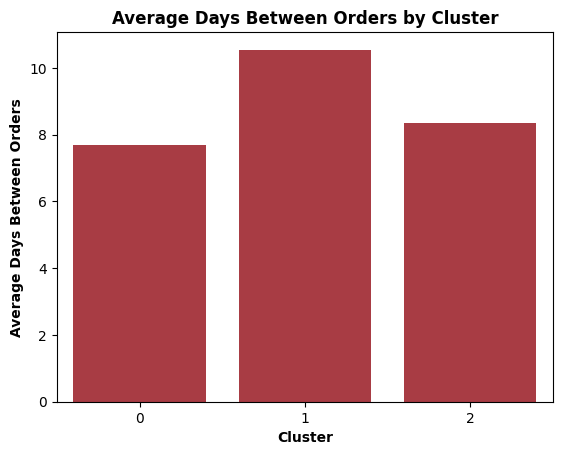

In [ ]:
#Avg Order Amt By Cluster
sns.barplot(data=df, x='Cluster', y='Total_Amt_Spent', errorbar=None, color = '#ba2a35')
plt.title('Average Order Amount by Cluster', fontweight = 'bold')
plt.xlabel('Cluster', fontweight = 'bold')
plt.ylabel('Average Order Amount', fontweight = 'bold')
plt.show()

#Avg Order Qty By Cluster
sns.barplot(data=df, x='Cluster', y='Quantity',errorbar=None, color = '#ba2a35')
plt.title('Average Order Quantity by Cluster', fontweight = 'bold')
plt.xlabel('Cluster', fontweight = 'bold')
plt.ylabel('Average Order Quantity', fontweight = 'bold')
plt.show()

#Avg Order Value By Cluster
sns.barplot(data=df, x='Cluster', y='Total_Price', errorbar=None, color = '#ba2a35')
plt.title('Average Order Value by Cluster', fontweight = 'bold')
plt.xlabel('Cluster', fontweight = 'bold')
plt.ylabel('Average Order Value', fontweight = 'bold')
plt.show()

#Days_Between_Orders
sns.barplot(data=df, x='Cluster', y='Days_Between_Orders', errorbar=None, color = '#ba2a35')
plt.title('Average Days Between Orders by Cluster', fontweight = 'bold')
plt.xlabel('Cluster', fontweight = 'bold')
plt.ylabel('Average Days Between Orders', fontweight = 'bold')
plt.show()

###Customer Descriptive Analytics

In [ ]:
!pip install pgeocode

In [ ]:
import pgeocode

In [ ]:
print(df['Zip_Code'].head())
print(df['Zip_Code'].dtype)

1    32726
2    32726
3    98022
4    32726
5    32726
Name: Zip_Code, dtype: object
object


In [ ]:
df['Zip_Code'].unique()

array(['32726', '98022', "'03106", ..., '64020', '47452', '92276-6646'],
      dtype=object)

In [ ]:
loc = df['Zip_Code']

In [ ]:
nomi = pgeocode.Nominatim('US')
query = nomi.query_postal_code(df['Zip_Code'].tolist())
loc_a = query[['postal_code', 'latitude', 'longitude']]
loc_a = loc_a.dropna(subset=['latitude', 'longitude'])
loc_a

,postal_code,latitude,longitude
0,32726,28.8550,-81.6789
1,32726,28.8550,-81.6789
2,98022,47.2665,-122.0314
3,32726,28.8550,-81.6789
4,32726,28.8550,-81.6789
...,...,...,...
5805,12302,42.8800,-73.9913
5806,12302,42.8800,-73.9913
5807,32409,30.3117,-85.6923
5808,32839,28.4871,-81.4082


<Axes: xlabel='longitude', ylabel='latitude'>

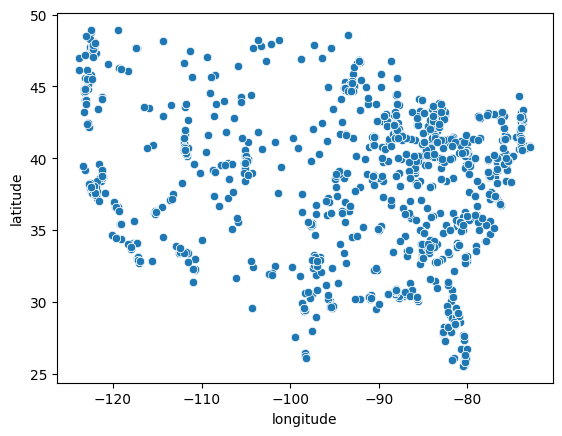

In [ ]:
#scatterplot of all customers
sns.scatterplot(data = loc_a, x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

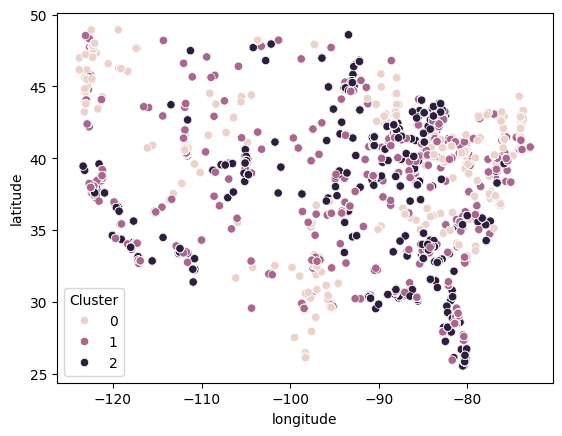

In [ ]:
#scatterplot based on cluster profiles
df_with_coords = df.merge(loc_a, left_on='Zip_Code', right_on='postal_code')

sns.scatterplot(data=df_with_coords, x='longitude', y='latitude', hue='Cluster')

###shapefile admin response needed

In [ ]:
#download the data (you only need to do this only once)
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip
#read the shapefile (get low resolution world file)
world = gpd.read_file('ne_110m_admin_0_countries.shp')

--2025-04-30 22:52:48--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.92.189.105, 52.92.209.185, 52.218.168.243, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.92.189.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 209.94K  --.-KB/s    in 0.1s    

2025-04-30 22:52:48 (1.97 MB/s) - ‘ne_110m_admin_0_countries.zip’ saved [214976/214976]

Archive:  ne_110m_admin_0_countries.zip
  inflating: ne_110m_admin_0_countries.README.html  
 extracting: ne_110m_admin_0_countries.VERSION.txt  
 extracting: ne_110m_admin_0_countries.cpg  
  inflating: ne_110m_admin_0_countries.dbf  
  inflating: ne_110m_admin_0_countries.prj  
  inflating: ne_110m_admin_0_countries.shp  
  inflating: ne_110m_admin_0_cou

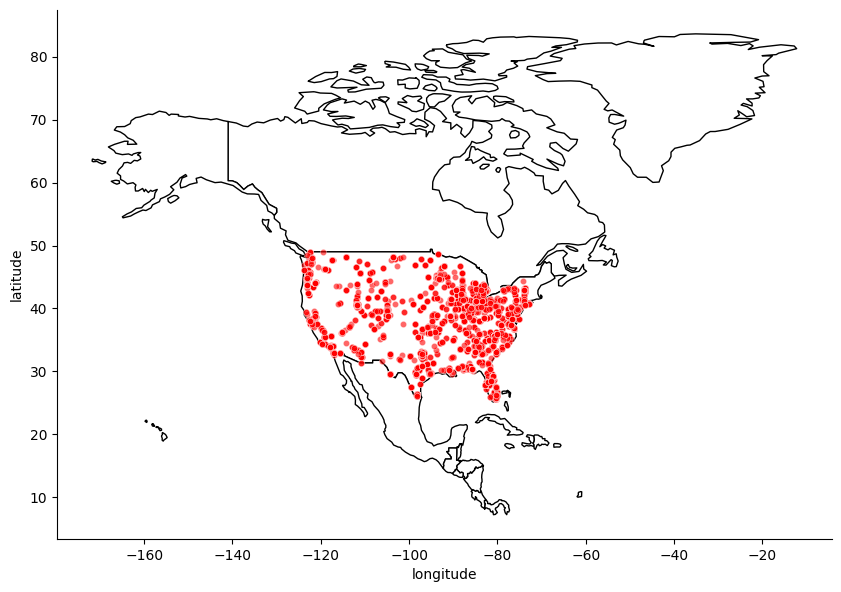

In [ ]:
#map of all customers in North America
#use the scatter plot info and place on map
fig, gax = plt.subplots(figsize=(10,10))  #set size of plot 10 x 10 in
#by only plotting rows in which the continenent is "north america"
world.query("CONTINENT == 'North America'").plot(ax = gax, color = 'white', edgecolor = 'black') #Use world.query(), to select only rows where CONTINENT is equal to North America. Black boarders and white fill.
gax.set_xlabel('longitude') #labels the x and y axes
gax.set_ylabel('latitude')
gax.spines['top'].set_visible(False)  #Hides the top and right borders of the plots
gax.spines['right'].set_visible(False)
sns.scatterplot(data=loc_a, x='longitude', y='latitude', ax=gax, color='red', s=20, alpha=0.6)

plt.show()

In [ ]:
# Drop invalid geometries
world = world[world.is_valid]
world = world.dropna(subset=['geometry'])
print(world['NAME'].unique())

['Fiji' 'Tanzania' 'W. Sahara' 'Canada' 'United States of America'
 'Kazakhstan' 'Uzbekistan' 'Papua New Guinea' 'Indonesia' 'Argentina'
 'Chile' 'Dem. Rep. Congo' 'Somalia' 'Kenya' 'Sudan' 'Chad' 'Haiti'
 'Dominican Rep.' 'Russia' 'Bahamas' 'Falkland Is.' 'Norway' 'Greenland'
 'Fr. S. Antarctic Lands' 'Timor-Leste' 'South Africa' 'Lesotho' 'Mexico'
 'Uruguay' 'Brazil' 'Bolivia' 'Peru' 'Colombia' 'Panama' 'Costa Rica'
 'Nicaragua' 'Honduras' 'El Salvador' 'Guatemala' 'Belize' 'Venezuela'
 'Guyana' 'Suriname' 'France' 'Ecuador' 'Puerto Rico' 'Jamaica' 'Cuba'
 'Zimbabwe' 'Botswana' 'Namibia' 'Senegal' 'Mali' 'Mauritania' 'Benin'
 'Niger' 'Nigeria' 'Cameroon' 'Togo' 'Ghana' "Côte d'Ivoire" 'Guinea'
 'Guinea-Bissau' 'Liberia' 'Sierra Leone' 'Burkina Faso'
 'Central African Rep.' 'Congo' 'Gabon' 'Eq. Guinea' 'Zambia' 'Malawi'
 'Mozambique' 'eSwatini' 'Angola' 'Burundi' 'Israel' 'Lebanon'
 'Madagascar' 'Palestine' 'Gambia' 'Tunisia' 'Algeria' 'Jordan'
 'United Arab Emirates' 'Qatar' 'Kuwait'

####Customer Denisty Across The US

The darker red the area, the higher concentration of cusomters. The midwest, southeast, and northeast are where our customers reside in the most. There are sparce, but visible clusters on the west coast and southwest regions with pockets of potential.

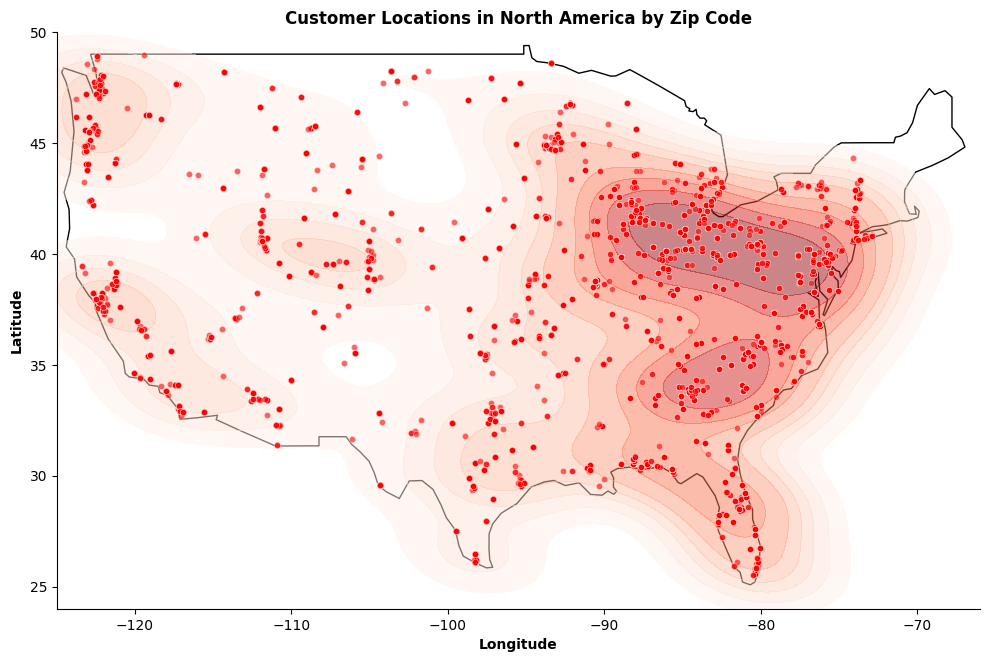

In [ ]:
#map of all customers in North America
#use the scatter plot info and place on map
fig, gax = plt.subplots(figsize=(10,10))  #set size of plot 10 x 10 in
#by only plotting rows in which the continenent is "north america"
world.query("NAME == 'United States of America'").plot(ax = gax, color = 'white', edgecolor = 'black') #Use world.query(), to select only rows where CONTINENT is equal to North America. Black boarders and white fill.
# Zoom into mainland U.S.
gax.set_xlim([-125, -66])  # Longitude: West Coast to East Coast
gax.set_ylim([24, 50])     # Latitude: Southern tip of Florida to Northern U.S.
gax.set_xlabel('Longitude',fontweight='bold')
gax.set_ylabel('Latitude',fontweight='bold')
gax.spines['top'].set_visible(False)  #Hides the top and right borders of the plots
gax.spines['right'].set_visible(False)

#visualize customer denisty
sns.kdeplot(data=loc_a, x='longitude', y='latitude', cmap="Reds", fill=True, alpha=0.5)
#Customer location
sns.scatterplot(data=loc_a, x='longitude', y='latitude', ax=gax, color='red', s=20, alpha=0.6)
plt.title('Customer Locations in North America by Zip Code', fontweight ='bold')
plt.savefig('customer_locations.png',transparent=True)
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
states = gpd.read_file("/content/drive/MyDrive/School/grad/Python/United States Shape Files/cb_2018_us_state_500k.zip")

DataSourceError: '/vsizip//content/drive/MyDrive/School/grad/Python/United States Shape Files/cb_2018_us_state_500k.zip' does not exist in the file system, and is not recognized as a supported dataset name.

#### Customer Profiles based on clusters

The customer cluster are geographically dispersed but patterns still emmerge:
 * Cluster 2 appears more often in the southeast and southwest.
 * Cluster 0 is widley scattered, suggesting general, low value behavior.
 * The midwest and east coast show higher cluster density overall.
  


In [ ]:
#map of customer profiles based on clusters
states = states[~states['STUSPS'].isin(['AK', 'HI', 'PR'])] #only show continental us as customers are only shown there.

fig, gax = plt.subplots(figsize=(10, 10))
states.plot(ax=gax, color='white', edgecolor='black')
states.plot(ax=gax, facecolor='none', edgecolor='gray', linewidth=0.8)

# Zoom into mainland U.S.
gax.set_xlim([-125, -66])
gax.set_ylim([24, 50])

color = ['#f6c2c2','#da0c0c','#1b0202']

# Add customer points
sns.scatterplot(
    data=df_with_coords,
    x='longitude',
    y='latitude',
    hue='Cluster',
    palette=color,
    s=25,
    alpha=0.7,
    ax=gax
)

gax.set_xlabel('Longitude',fontweight ='bold')
gax.set_ylabel('Latitude',fontweight ='bold')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.title('Customer Clusters by U.S. State',fontweight ='bold')
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
states.columns

In [ ]:
states['STUSPS']

In [ ]:
#calculate total amount per customer on map
spending_by_state = df.groupby('State')['Total_Amt_Spent'].sum().reset_index()
spending_by_state
choropleth_data  = spending_by_state.merge(states, left_on='State', right_on='STUSPS')

In [ ]:
import geopandas as gpd
choropleth_data = gpd.GeoDataFrame(choropleth_data, geometry='geometry')

In [ ]:
choropleth_data = choropleth_data[['STUSPS', 'NAME', 'geometry', 'Total_Amt_Spent']]
choropleth_data = choropleth_data[choropleth_data.is_valid]
choropleth_data['geometry'] = choropleth_data['geometry'].simplify(0.01)
choropleth_geojson = choropleth_data.to_json()

####Customer Spending Choropleth by US State

Total revenue generated by customers aggregated by state, the darker the red, the higher the total spend. The top spending states include Virginia, North Carolina, Texas, and Georgia. States like California, New York, and Illinois are not as dark depsite population size, suggesting potenitally underdeveloped markets.

In [ ]:
import folium

# Create base map
m = folium.Map(location=[37.8, -96], zoom_start=4, tiles='CartoDB positron')


# Add choropleth layer
folium.Choropleth(
    geo_data=choropleth_geojson,
    data=spending_by_state,
    columns=['State', 'Total_Amt_Spent'],
    key_on='feature.properties.STUSPS',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='lightgray',
    legend_name='Total Amount Spent ($)',
).add_to(m)

# Add a centered HTML title
title_html = '''
     <h3 align="center" style="font-size:20px"><b>Total Customer Spending by State</b></h3>
     '''
m.get_root().html.add_child(folium.Element(title_html))

# Show the map
m


##Linear Regression

prep for linear

In [ ]:
customers_df = pd.read_csv("/content/customers_clean_2.csv")
transactions_df = pd.read_csv("/content/transactions_clean_2.csv")
trans_details_df = pd.read_csv("/content/trans_details_clean_2.csv")

In [ ]:
trans_details_df["Order_Date"] = pd.to_datetime(trans_details_df["Order_Date"])

customer_orders = trans_details_df[["Customer_ID", "Order_Num", "Order_Date"]].drop_duplicates()

customer_orders = customer_orders.sort_values(by=["Customer_ID", "Order_Date"])

customer_orders["Time_To_Next"] = customer_orders.groupby("Customer_ID")["Order_Date"].shift(-1) - customer_orders["Order_Date"]
customer_orders["Time_To_Next_Days"] = customer_orders["Time_To_Next"].dt.days
customer_orders["Repurchased"] = customer_orders["Time_To_Next_Days"].notna().astype(int)
customer_orders["Prior_Order_Count"] = customer_orders.groupby("Customer_ID").cumcount()

customer_orders.head(50)

,Customer_ID,Order_Num,Order_Date,Time_To_Next,Time_To_Next_Days,Repurchased,Prior_Order_Count
0,7110361907351,1006,2024-01-30,NaT,NaN,0,0
3487,7110414041239,2531,2024-08-29,NaT,NaN,0,0
596,7110686802071,1268,2024-03-21,0 days,0.0,1,0
597,7110686802071,1270,2024-03-21,4 days,4.0,1,1
654,7110686802071,1287,2024-03-25,14 days,14.0,1,2
839,7110686802071,1363,2024-04-08,15 days,15.0,1,3
1049,7110686802071,1459,2024-04-23,15 days,15.0,1,4
1292,7110686802071,1573,2024-05-08,7 days,7.0,1,5
1418,7110686802071,1612,2024-05-15,1 days,1.0,1,6
1437,7110686802071,1625,2024-05-16,1 days,1.0,1,7


In [ ]:
#Aggregate category quantities per order (sum of Quantity)
category_quantity = trans_details_df[["Customer_ID", "Order_Num", "Category", "Quantity"]].dropna()
category_summary = category_quantity.groupby(["Customer_ID", "Order_Num", "Category"]).agg({"Quantity": "sum"}).reset_index()
print('Catergory Qty', category_quantity)
print('Category Summary', category_summary)

Catergory Qty         Customer_ID  Order_Num                    Category  Quantity
0     7110361907351       1006        Sewer Jetter Nozzles         1
1     7116653166743       1008  Vacuum Truck Hose Fittings         1
2     7116653166743       1008            Hydro Excavation         1
3     7116382634135       1007               Manhole Tools         2
4     7116653166743       1008  Vacuum Truck Hose Fittings         4
...             ...        ...                         ...       ...
5939  7165283598487       3570  Vacuum Truck Hose Fittings         6
5940  7165283598487       3570  Vacuum Truck Hose Fittings         2
5941  7363956179095       3572                 Jetter Hose         1
5942  7864100814999       3567                 Jetter Hose         1
5943  7165283598487       3570          Vacuum Truck Parts         6

[5944 rows x 4 columns]
Category Summary         Customer_ID  Order_Num                    Category  Quantity
0     7110361907351       1006        Sewer Jet

##Cox Proportional Hazards

**Equation**

The hazard at time *t* for customer *i* is:

$$
h_i(t) = h_0(t) \cdot \exp(\beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_k x_{ik})
$$

- $( h_0(t) )$: Baseline hazard (shared across all customers)  
- $( x_{ij} )$: Covariates (e.g., Level, Basket Size, Time Between Purchases)  
- $( \beta_j )$: Model coefficients (effect size)

---

**Why CPH is Great for Business Use:**

- Doesn’t assume a shape for baseline time distribution (**flexible**)
- You get **interpretable effects of covariates**
- Works well with **censored data**

---

The objective is to identify the timing of when a customer is most likely to repurchase, and to understand the key factors influencing this behavior.

We aim to analyze, plot, and rank customers based on their likelihood to repurchase, helping us prioritize marketing and sales strategies accordingly.

The Cox Proportional Hazards model was selected because:
 * It does not assume a specific shape for the baseline time distribution, offering flexibility in modeling diverse customer behaviors.

* It provides interpretable coefficients for covariates, allowing us to clearly understand the impact of different factors on repurchase timing.

* It is well-suited for censored data, which is common when customers have not yet made a repeat purchase within the observation window.

Key factors under consideration include:

* Cumulative spending: The total amount a customer has spent previously.

* Industry proxy through product categories: Using the types of products purchased as indicators of the customer's industry, supplemented by domain knowledge.

Rather than analyzing purchases at the individual product level — which would introduce excessive complexity — we propose to model behavior based on a limited set of high-level product categories.
This will allow for more interpretable, scalable, and actionable insights.


In [ ]:
#ensure order_date in trans_details_df is in datetime format
trans_details_df["Order_Date"] = pd.to_datetime(trans_details_df["Order_Date"])

#check for duplicates
customer_orders = trans_details_df[["Customer_ID", "Order_Num", "Order_Date"]].drop_duplicates()

#sort cutomers table by customer_id and order_date
customer_orders = customer_orders.sort_values(by=["Customer_ID", "Order_Date"])

#add Time_To_Next col to customer_orders, getting results by grouping by customer_ID and order_date, calculating how many days till next purchase.
customer_orders["Time_To_Next"] = customer_orders.groupby("Customer_ID")["Order_Date"].shift(-1) - customer_orders["Order_Date"]

#make this column date time to interger to count number of days
customer_orders["Time_To_Next_Days"] = customer_orders["Time_To_Next"].dt.days

# assign 0 to a new column called repurchase if there was not a next order date calculated in the times_to_next days column (number of days till next purchase), and it will assign 1 if there was
customer_orders["Repurchased"] = customer_orders["Time_To_Next_Days"].notna().astype(int)

#create a new column prior_order_count to count how many orders have been placed previously from the current order
customer_orders["Prior_Order_Count"] = customer_orders.groupby("Customer_ID").cumcount()

#Aggregate category quantities per order (sum of Quantity)
category_quantity = trans_details_df[["Customer_ID", "Order_Num", "Category", "Quantity"]].dropna()
# shows, for each customer and order, how many units of each product category they purchased.
category_summary = category_quantity.groupby(["Customer_ID", "Order_Num", "Category"]).agg({"Quantity": "sum"}).reset_index()

category_summary

,Customer_ID,Order_Num,Category,Quantity
0,7110361907351,1006,Sewer Jetter Nozzles,1
1,7110414041239,2531,Vacuum Truck Parts,10
2,7110686802071,1268,Vacuum Truck Hose Fittings,4
3,7110686802071,1270,Vacuum Truck Hose Fittings,37
4,7110686802071,1270,Vacuum Truck Parts,5
...,...,...,...,...
3854,7872750780567,3560,Hydroexcavation Trigger,1
3855,7873460011159,3561,Jetter Hose,7
3856,7873639252119,3564,Vacuum Truck Hose Fittings,3
3857,7874198470807,3566,Hydro Excavation,3


In [ ]:
#Pivot to wide format (category columns)--to see how mamy categories in total we have
category_pivot = category_summary.pivot_table(index=["Customer_ID", "Order_Num"],columns="Category",values="Quantity",fill_value=0).reset_index()
category_pivot

Category,Customer_ID,Order_Num,Chemicals,Confined Space,Hurco Smoke Testing,Hydro Excavation,Hydro Excavation Nozzle,Hydroexcavation Trigger,Jetter Hose,Lansas Pipe Plugs,...,Sewer Crawler Supplies,Sewer Jetter Nozzles,Vacuum Truck Custom Adapters,Vacuum Truck Filters,Vacuum Truck Hose,Vacuum Truck Hose Fittings,Vacuum Truck Parts,Vacuum Truck Pumps,Vacuum Truck Tubes,Vacuum Truck Valves
0,7110361907351,1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7110414041239,2531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
2,7110686802071,1268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
3,7110686802071,1270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,37.0,5.0,0.0,0.0,0.0
4,7110686802071,1287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,7872750780567,3560,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2512,7873460011159,3561,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2513,7873639252119,3564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2514,7874198470807,3566,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
category_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer_ID                   2516 non-null   int64  
 1   Order_Num                     2516 non-null   int64  
 2   Chemicals                     2516 non-null   float64
 3   Confined Space                2516 non-null   float64
 4   Hurco Smoke Testing           2516 non-null   float64
 5   Hydro Excavation              2516 non-null   float64
 6   Hydro Excavation Nozzle       2516 non-null   float64
 7   Hydroexcavation Trigger       2516 non-null   float64
 8   Jetter Hose                   2516 non-null   float64
 9   Lansas Pipe Plugs             2516 non-null   float64
 10  Manhole Tools                 2516 non-null   float64
 11  Sewer Crawler Supplies        2516 non-null   float64
 12  Sewer Jetter Nozzles          2516 non-null   float64
 13  Vac

In [ ]:
# Keep only necessary columns before merging
customer_orders = customer_orders[["Customer_ID", "Order_Num", "Order_Date", "Time_To_Next", "Time_To_Next_Days", "Repurchased", "Prior_Order_Count"]]

# Then safely merge
customer_orders = pd.merge(
    customer_orders,
    category_pivot,
    on=["Customer_ID", "Order_Num"],
    how="left",
    suffixes=('', '_drop')  # still extra protection
)

# Drop any '_drop' columns just in case
customer_orders = customer_orders.drop(columns=[col for col in customer_orders.columns if col.endswith('_drop')])

# Subset of customer metadata to merge
customer_info = customers_df[[
    "Customer_ID", "Default Address Province Code","Customer_Type"
]]


In [ ]:
customer_orders.columns

Index(['Customer_ID', 'Order_Num', 'Order_Date', 'Time_To_Next',
       'Time_To_Next_Days', 'Repurchased', 'Prior_Order_Count', 'Chemicals',
       'Confined Space', 'Hurco Smoke Testing', 'Hydro Excavation',
       'Hydro Excavation Nozzle', 'Hydroexcavation Trigger', 'Jetter Hose',
       'Lansas Pipe Plugs', 'Manhole Tools', 'Sewer Crawler Supplies',
       'Sewer Jetter Nozzles', 'Vacuum Truck Custom Adapters',
       'Vacuum Truck Filters', 'Vacuum Truck Hose',
       'Vacuum Truck Hose Fittings', 'Vacuum Truck Parts',
       'Vacuum Truck Pumps', 'Vacuum Truck Tubes', 'Vacuum Truck Valves'],
      dtype='object')

In [ ]:
customer_info

In [ ]:
customer_info.info()
customer_info['Customer_ID']=customer_info['Customer_ID'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Customer_ID                    1393 non-null   int64 
 1   Default Address Province Code  1392 non-null   object
 2   Customer_Type                  1393 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 32.8+ KB


<ipython-input-160-3ea9192a1439>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_info['Customer_ID']=customer_info['Customer_ID'].astype(int)


In [ ]:
#create temprorary df that includes product category, email domain info, and address provice code
temp_survival_df = pd.merge(customer_orders, customer_info, on="Customer_ID", how="left")
temp_survival_df


#Group the transactions by Customer_ID and Order_Num.
#Sum the Total_Price within each order to get the total amount for that order
order_amounts = trans_details_df.groupby(["Customer_ID", "Order_Num"])["Total_Price"].sum().reset_index()

#Rename the summed Total_Price column to Order_Amount for clarity.
order_amounts.rename(columns={"Total_Price": "Order_Amount"}, inplace=True)

#Merge the order_amounts back into the temp_survival_df on Customer_ID and Order_Num.
temp_survival_df = pd.merge(temp_survival_df, order_amounts, on=["Customer_ID", "Order_Num"], how="left")

#Convert the Order_Date column to proper datetime format (so you can sort and calculate on dates correctly).
temp_survival_df["Order_Date"] = pd.to_datetime(temp_survival_df["Order_Date"])

#Sort the dataset by Customer_ID and Order_Date to put all orders in correct chronological order for each customer.
temp_survival_df = temp_survival_df.sort_values(by=["Customer_ID", "Order_Date"])

#Calculate cumulative spending: For each customer, add up the Order_Amount over time (running total).
temp_survival_df["Cumulative_Spent_Total"] = temp_survival_df.groupby("Customer_ID")["Order_Amount"].cumsum()
temp_survival_df[["Customer_ID", "Order_Num", "Order_Date", "Order_Amount", "Cumulative_Spent_Total"]].head(10)

,Customer_ID,Order_Num,Order_Date,Order_Amount,Cumulative_Spent_Total
0,7110361907351,1006,2024-01-30,705.21,705.21
1,7110414041239,2531,2024-08-29,162.40,162.40
2,7110686802071,1268,2024-03-21,504.14,504.14
3,7110686802071,1270,2024-03-21,2764.21,3268.35
4,7110686802071,1287,2024-03-25,1139.95,4408.30
5,7110686802071,1363,2024-04-08,263.56,4671.86
6,7110686802071,1459,2024-04-23,419.81,5091.67
7,7110686802071,1573,2024-05-08,1337.15,6428.82
8,7110686802071,1612,2024-05-15,1833.12,8261.94
9,7110686802071,1625,2024-05-16,1285.31,9547.25


In [ ]:
new_df = temp_survival_df
new_df

,Customer_ID,Order_Num,Order_Date,Time_To_Next,Time_To_Next_Days,Repurchased,Prior_Order_Count,Chemicals,Confined Space,Hurco Smoke Testing,...,Vacuum Truck Hose,Vacuum Truck Hose Fittings,Vacuum Truck Parts,Vacuum Truck Pumps,Vacuum Truck Tubes,Vacuum Truck Valves,Default Address Province Code,Customer_Type,Order_Amount,Cumulative_Spent_Total
0,7110361907351,1006,2024-01-30,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,TN,0.0,705.21,705.21
1,7110414041239,2531,2024-08-29,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,NaN,NaN,162.40,162.40
2,7110686802071,1268,2024-03-21,0 days,0.0,1,0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,MS,1.0,504.14,504.14
3,7110686802071,1270,2024-03-21,4 days,4.0,1,1,0.0,0.0,0.0,...,0.0,37.0,5.0,0.0,0.0,0.0,MS,1.0,2764.21,3268.35
4,7110686802071,1287,2024-03-25,14 days,14.0,1,2,0.0,0.0,0.0,...,0.0,21.0,0.0,0.0,0.0,0.0,MS,1.0,1139.95,4408.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,7872750780567,3560,2024-12-29,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,IL,0.0,439.34,439.34
2512,7873460011159,3561,2024-12-30,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,IN,1.0,3316.78,3316.78
2513,7873639252119,3564,2024-12-30,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,MO,1.0,225.52,225.52
2514,7874198470807,3566,2024-12-30,NaT,NaN,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,MT,0.0,523.68,523.68


###Baseline Model


Initial baseline modeling was ran with a concordance of 0.62, which is a decent score with limited observations. Partial AIC is 15018.32

Cumulative_Spent_Total (CST) was expected to be significant based on general assumption in customer lifetime value, retention and loyalty models or studies that bigger spenders are usually more loyal, more engaged, and are more likely to repurchase faster. Although there is a low p-value of <0.005, showing statistical significance, the coefficient is still 0, showing neutral effect. While we can statistically detect an association, the practical effect is negligible. In other words, changes in cumulative spending do not meaningfully impact the customer's likelihood to repurchase faster.

Prior_Order_Count has a positive coefficient of 0.03 and exp(coef) is around 1.03, meaning every additional prior order increases repurchase hazard by about 3%. So, customers with more prior orders are more likely to repurchase sooner, specifically additional prior orders increases the chance the customer will repurchase ~3% faster.

Customer_Type has a positive coefficient of 0.18 and exp(coef) of 1.19, showing certain customer types are 19% more likely to repurchase faster.

In [ ]:
# !pip install lifelines
from lifelines import CoxPHFitter
import pandas as pd

In [ ]:
# Filter only rows where we know time to next purchase
cox_data = new_df[new_df["Time_To_Next_Days"].notnull()].copy()

# Select modeling variables
cox_vars = [
    "Time_To_Next_Days",
    "Repurchased",
    "Cumulative_Spent_Total",
    "Prior_Order_Count",
    "Customer_Type"
]
cox_data_clean = cox_data[cox_vars].dropna()

# Fit the model
cox_model = CoxPHFitter()
cox_model.fit(cox_data_clean, duration_col="Time_To_Next_Days", event_col="Repurchased")

# Print the results
cox_model.print_summary()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Prepare predictors (X matrix)
X = cox_data_clean.drop(columns=["Time_To_Next_Days", "Repurchased"])

# (Optional but safer) Add constant term (intercept) to X
X = X.assign(const=1)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Remove constant term from results
vif_data = vif_data[vif_data["Feature"] != "const"]

# Show VIF
vif_data


In [ ]:
final_df = new_df

category_columns = [
    col for col in final_df.columns
    if col not in [
        'Unnamed: 0', 'Customer_ID', 'Order_Num', 'Order_Date', 'Time_To_Next',
        'Time_To_Next_Days', 'Repurchased', 'Prior_Order_Count',
        'Default Address Province Code', 'Personal_Email',
        'Order_Amount', 'Cumulative_Spent_Total'
    ] and final_df[col].dtype in ['int64', 'float64']
]

# Rebuild dataset with survival and modeling variables
cox_vars_extended = [
    "Time_To_Next_Days",
    "Repurchased",
    "Cumulative_Spent_Total",
    "Prior_Order_Count",
    "Customer_Type"
] + category_columns

# Drop rows with missing values in relevant columns
#cox_data_extended = df[cox_vars_extended].dropna()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Drop rows with missing survival time
cox_data_raw = final_df[cox_vars_extended].dropna()

In [ ]:
# Separate predictors (exclude duration + event)
X = cox_data_raw.drop(columns=["Time_To_Next_Days", "Repurchased"])

selector = VarianceThreshold(threshold=0.01)  # 1% variance minimum
X_reduced = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

X_reduced

In [ ]:
cox_data_cleaned = pd.concat([
    cox_data_raw[["Time_To_Next_Days", "Repurchased"]].reset_index(drop=True),
    X_reduced.reset_index(drop=True)
], axis=1)

cox_data_cleaned

###Baseline with tenure and cumulative  number of items purchased


We ran the baseline model a second time with the consideration of customer tenure, customer lifetime, utilizing first inital order and the number of orders. Adding tenure helps control for the customer's lifecycle stage. Since
Prior_Order_Count infers that the more purchase history there is, the faster the customer comes back to reprucahse, to be confident we must add a control variable. If not included, the model may mistake "newness" for "low loyalty," or vice versa. The number of orders is a signifier of loyalty and engagement. Customers who have bought multiple times are usually much more likely to buy again. This will give a more rounded view of customer behavior.


With the addition of customer tenure and number of orders added to the model, the results show that Cumulative_Spent_Total remains the same and that Prior_Order_Count and Customer_Type loss significance after controlling for additional variables. Prior_Order_Count has a negative coefficient of -0.0, esentially showing no real impact on the time to repurchase and a p-value of 0.82,showing no statisitcal significane. It  is now redundant because of better loyalty indicators because spend amount itself does not drive faster return behavior.


For Customer_Type, there is a coefficient and p-value of 0.11. While it shows customers of a certain type are predicted to have a 12% higher hazard (1.12 times) of repurchasing. (exp(0.11) ≈ 1.12), the evidence is weak (p = 0.11), so we cannot confidently say that customer type actually affects repurchase timing based on this sample.

With the new variables, there is a postive coefficient of 0.03 for Num_Of_Orders with a high p-value of <0.005, meaning that customers with higher the number of total lifetime orders, the faster they will repurchase and every additional lifetime order increases the hazard of repurchasing by about 3%. We can confidently say that customers with more prior orders return faster with the high p-value.

For Customer_Tenure_Days, there is a -0.00, showing longer tenure (being a customer for more days) very slightly slows down repurchasing and a negligible effect, hazard changes minimally per additional day. There is a slight statistical siginicance with a p-value of <0.005. So, older customers are slgihtly less likely to repruchase over time. This is likely due to customer fatigue in regards of poor operation, customer service. There has recently been large delays in turnaround and lead time, customers could get frustrated and lose trust and enthusiasm. With this being said, poor customer service comes behind these delays with lack of effort for solutions and strict company policies, causing hesitation to renegage quickly.












In [ ]:
#add column that controls overall tenure of the customers - how many dayss has been passed since this customer has joined (1st inital order -lifetime)

#upload data
customer_prediction_df = pd.read_csv('/content/drive/Shareddrives/Advanced Data Analytics /Project /DA project 1/Customer Purchase Prediction Time - 2023-01-01 - 2025-04-24.csv')
customer_prediction_df

#rename cols
customer_prediction_df.rename(columns={
    'Customer ID':'Customer_ID',
    'Customer email': 'Email',
    'Customer email domain':'Email_Domain',
    'Customer number of orders':'Num_of_Orders',
    'Customer last order date':'Last_Order_Date',
    'Customer first order date':'First_Order_Date',
    'Order name':'Order_Num'
    }, inplace=True)

#drop customers and orders
customer_prediction_df.drop(columns=['Customers', 'Orders','Email','Email_Domain'], inplace=True)

#change to datetime
customer_prediction_df['First_Order_Date'] = pd.to_datetime(customer_prediction_df['First_Order_Date'])
customer_prediction_df['Last_Order_Date'] = pd.to_datetime(customer_prediction_df['Last_Order_Date'])
customer_prediction_df.info()

#drop row with null value
customer_prediction_df.dropna(inplace=True)

#remove # in order_num
pattern = r'^#'
customer_prediction_df['Order_Num'] = customer_prediction_df['Order_Num'].str.replace(pattern, '', regex=True)

#change object dt to int dt for order_num
customer_prediction_df['Order_Num'] = customer_prediction_df['Order_Num'].astype(int)

In [ ]:
today = pd.to_datetime('2025-04-24')
customer_prediction_df['Customer_Tenure_Days'] = (customer_prediction_df['Last_Order_Date'] - customer_prediction_df['First_Order_Date']).dt.days

In [ ]:
#merge customer_prediction_df with temp_survival_df by order_num and Customer_ID
temp_survival_df = pd.merge(temp_survival_df, customer_prediction_df , on=["Customer_ID", "Order_Num"], how="left")

In [ ]:
new_df2 = temp_survival_df
new_df2.columns

In [ ]:
# Drop _y columns (duplicated category columns from customer_prediction_df)
new_df2 = new_df2.drop(columns=[col for col in new_df2.columns if col.endswith('_y')])

# Rename _x columns to remove _x suffix
new_df2 = new_df2.rename(columns={col: col.replace('_x', '') for col in new_df2.columns if col.endswith('_x')})


In [ ]:
# Filter only rows where we know time to next purchase
cox_data = new_df2[new_df2["Time_To_Next_Days"].notnull()].copy()

# Select modeling variables
cox_vars = [
    "Time_To_Next_Days",
    "Repurchased",
    "Cumulative_Spent_Total",
    "Prior_Order_Count",
    "Customer_Type",
    "Num_of_Orders",
    "Customer_Tenure_Days"
]
cox_data_clean = cox_data[cox_vars].dropna()

# Fit the model
cox_model = CoxPHFitter()
cox_model.fit(cox_data_clean, duration_col="Time_To_Next_Days", event_col="Repurchased")

# Print the results
cox_model.print_summary()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming your predictors are in a dataframe X:
X = cox_data_clean.drop(columns=["Time_To_Next_Days", "Repurchased"])

# Add a constant column for VIF calculation (needed sometimes)
X = X.assign(const=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop the constant row from VIF results (not meaningful)
vif_data = vif_data[vif_data["Feature"] != "const"]

vif_data


###Graphs

In [ ]:
temp_survival_df

In [ ]:
new_df2

In [ ]:
cox_data_clean

####Customer 0

In [ ]:
# Save Customer_IDs separately
customer_ids = new_df2.loc[cox_data_clean.index, "Customer_ID"].reset_index(drop=True)

# Predict survival function
X_pred = cox_data_clean.drop(columns=["Time_To_Next_Days", "Repurchased"])
surv_curves = cox_model.predict_survival_function(X_pred)

# Identify Customer 0
def print_customer_info(index):
    print(f"customer {index}: {customer_ids.iloc[index]}")

# Example usage
print_customer_info(0)

In [ ]:
# Select predictors only (same ones used in the model)
X_pred = cox_data_clean.drop(columns=["Time_To_Next_Days", "Repurchased"])

# Predict survival curves
surv_curves = cox_model.predict_survival_function(X_pred)

# Plot for example customer
plt.figure()
surv_curves.iloc[:, 0].plot(title="Survival Curve for Customer 0",xlabel="Days Since Purchase",ylabel="Survival Probability",color="red")

plt.title("Survival Curve for Customer 0", fontweight="bold")
plt.xlabel("Days Since Purchase", fontweight="bold")
plt.ylabel("Survival Probability", fontweight="bold")

plt.savefig('survival_curve(1).png', transparent=True)
plt.show()

####Customer 100

In [ ]:
# Plot for an example customer
plt.figure()

surv_curves.iloc[:, 100].plot(title="Survival Curve for Customer 100", xlabel="Days Since Purchase",ylabel="Survival Probability", color="red")


plt.title("Survival Curve for Customer 100", fontweight="bold")
plt.xlabel("Days Since Purchase", fontweight="bold")
plt.ylabel("Survival Probability", fontweight="bold")

plt.savefig('survival_curve(2).png', transparent=True)
plt.show()

print_customer_info(100)

####All Customers

In [ ]:
plt.figure(figsize=(12,8))
for i in range(surv_curves.shape[1]):
    plt.step(surv_curves.index, surv_curves.iloc[:, i], alpha=0.1, color="red")
plt.title("Survival Curves for All Customers", fontweight="bold")
plt.xlabel("Days Since Purchase", fontweight="bold")
plt.ylabel("Survival Probability", fontweight="bold")
plt.grid(True)
plt.show()

####Survival Curves by Customer Type

In [ ]:
cox_data_clean

In [ ]:
# Step 1: Find out what columns model expects
expected_cols = cox_model.params_.index.tolist()

# Step 2: Subset correctly
X_pred = cox_data_clean[expected_cols]

# Step 3: Predict
median_times = cox_model.predict_median(X_pred)
cox_data_cleaned["Predicted_Median_Days_To_Return"] = median_times
cox_data_cleaned[["Predicted_Median_Days_To_Return"]].head()


In [ ]:
# Step 1: Get predictors correctly
X_pred = cox_data_clean[cox_model.params_.index]

# Step 2: Predict median survival time
median_times = cox_model.predict_median(X_pred)

# Step 3: Create comparison dataframe properly
comparison_df = cox_data_cleaned.copy()
comparison_df["Predicted_Median_Days_To_Return"] = median_times

# Step 4: Add actual days from final_df
comparison_df["Actual_Days_To_Return"] = final_df.loc[comparison_df.index, "Time_To_Next_Days"]

# Step 5: Select relevant columns
comparison_result = comparison_df[[
    "Predicted_Median_Days_To_Return",
    "Actual_Days_To_Return"
]].dropna()

# Step 6: View
comparison_result.head(10)


In [ ]:
cox_data_clean

In [ ]:
import matplotlib.pyplot as plt

# Map customer type codes to names
customer_type_labels = {
    0: "Level 1",
    1: "Priority Access"
}

# Set specific colors for each customer type
customer_type_colors = {
    0: "darkred",      # Level 1 -> darkred
    1: "red"        # Priority Access -> Red
}

# Group survival functions by customer type
groups = cox_data_clean.groupby("Customer_Type")

# Plot survival curves
plt.figure(figsize=(10, 6))

for name, group in groups:
    # Match the exact predictors used in training
    X_pred = group[cox_model.params_.index]

    # Predict survival function
    surv_fn = cox_model.predict_survival_function(X_pred)
    avg_surv = surv_fn.mean(axis=1)

    label_name = customer_type_labels.get(name, f"Customer Type {name}")
    color = customer_type_colors.get(name, "gray")  # Default to gray if missing
    plt.step(avg_surv.index, avg_surv.values, where="post", label=label_name, color=color)

plt.title("Survival Curves by Customer Type (Predicted Probability of Not Yet Returning)", fontweight="bold")
plt.xlabel("Days Since Purchase", fontweight="bold")
plt.ylabel("Survival Probability", fontweight="bold")
plt.legend(title="Customer Type", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()




##Association

In [ ]:
df['Category'] = df['Category'].str.lower().str.strip()
transactions = df.groupby('Order_Num')['Category'].apply(list).tolist()

from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

In [ ]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

In [ ]:
rules.sort_values(by='confidence', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
114,"(vacuum truck tubes, hydro excavation, vacuum ...",(vacuum truck hose fittings),0.005686,0.666667,2.378744
102,"(vacuum truck tubes, vacuum truck hose)",(vacuum truck hose fittings),0.005686,0.666667,2.378744
59,"(vacuum truck tubes, hydro excavation)",(vacuum truck hose fittings),0.015435,0.633333,2.259807
105,"(vacuum truck tubes, vacuum truck hose)",(vacuum truck parts),0.005280,0.619048,2.801646
55,"(hydro excavation, vacuum truck parts)",(vacuum truck hose fittings),0.018684,0.589744,2.104274
111,"(vacuum truck valves, vacuum truck parts)",(vacuum truck hose fittings),0.007311,0.580645,2.071809
92,"(manhole tools, vacuum truck tubes)",(vacuum truck parts),0.007717,0.575758,2.605726
1,(hydroexcavation trigger),(hydro excavation),0.011779,0.547170,3.111160
49,"(manhole tools, hydro excavation)",(vacuum truck hose fittings),0.007717,0.527778,1.883172
83,"(jetter hose, vacuum truck tubes)",(vacuum truck hose fittings),0.007311,0.514286,1.835031


In [ ]:
frequent_itemsets['support_count'] = frequent_itemsets['support'] * len(df_encoded)
frequent_itemsets = frequent_itemsets.sort_values(by='support_count', ascending=False)

frequent_itemsets.head(10)

,support,itemsets,support_count
11,0.280260,(vacuum truck hose fittings),690.0
12,0.220959,(vacuum truck parts),544.0
4,0.217709,(jetter hose),536.0
1,0.175873,(hydro excavation),433.0
6,0.160439,(manhole tools),395.0
13,0.135662,(vacuum truck tubes),334.0
7,0.106824,(sewer jetter nozzles),263.0
46,0.081641,"(vacuum truck hose fittings, vacuum truck parts)",201.0
10,0.071893,(vacuum truck hose),177.0
14,0.055646,(vacuum truck valves),137.0
